In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from beeid2.models import simple_cnnv2, ContrastiveLearning
from beeid2.data_utils import filename2image
from beeid2.evaluation import mAP_evaluation, mAP_track_model_evaluation, cmc_track_model_evaluation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from tqdm import tqdm
import glob
from skimage import io
from beeid2.evaluation import get_query_galleries, plot_query_gallery, get_query_galleries_tracks
from collections import defaultdict

def to_np_array(values, dim=128):
    return np.concatenate(list(values)).reshape(-1, dim)


EVALUATION_FILES = {
    "test": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv",
    "valid_with_shared_ids_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/valid_with_shared_ids_unnormalized.csv",
    "valid_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/valid_galleries_unnormalized.csv",
    "test_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_galleries_unnormalized.csv",
    "test_no_train_overlap_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_no_train_overlap_unnormalized.csv",
    "test_same_hour_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_same_hour2_unnormalized.csv",
    "test_same_hour_diff_day_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day_same_hour2_unnormalized.csv",
    "test_diff_day_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day2_unnormalized.csv",
    "track_test_same_hour": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_same_hour3_unnormalized.csv",
    "track_test_same_hour_diff_day": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day_same_hour3_unnormalized.csv",
    "track_test_diff_day": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day3_unnormalized.csv",

}



In [3]:
MODEL = "../../models2/2111240952_tagged_augmentataion_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf/"

In [4]:
base_model = load_model(MODEL)

In [5]:
queryG = get_query_galleries(base_model)

13/13 [==============================] - 1s 103ms/step


100%|██████████| 654/654 [00:02<00:00, 255.43it/s]


In [6]:
APs = defaultdict(list)
topN = defaultdict(list)
N=1
for qg in queryG:
    
    query, gallery = qg
    query = query.iloc[0]
    query_id = query.track_tag_id
    query = np.expand_dims(query.emb, axis=0)

    labels = gallery.track_tag_id.values
    distances = tf.matmul(query, to_np_array(gallery["emb"].values).T)
    distances = np.squeeze(distances.numpy())
    
    # mAP
    binary_labels = (labels == query_id).astype(bool)
    precision, recall, thresholds = precision_recall_curve(binary_labels, distances)
    AP = auc(recall, precision)
    APs[query_id].append(AP)
    
    # Top N accuracy 
    min_idx = np.argsort(distances)
    predicted_ids = labels[min_idx[-N:]]
    acc = np.any(predicted_ids == query_id)
    topN[query_id].append(acc)

metrics = dict()
metrics["id"] = list()
metrics["mAP"] = list()
metrics["n"] = list()
metrics["top1"] = list()
for tag_id in APs:
    metrics["id"].append(tag_id)
    metrics["mAP"].append(np.mean(APs[tag_id]))
    metrics["n"].append(len(APs[tag_id]))
    metrics["top1"].append(np.mean(topN[tag_id]))

In [7]:
sorted_mAP_indx = np.argsort(metrics["mAP"])[::-1]
sorted_topN_indx = np.argsort(metrics["top1"])[::-1]

In [8]:
sorted_mAP_indx

array([48, 23, 41, 32, 16, 33, 28, 24, 61, 10, 17, 20, 49, 60,  4, 19, 35,
        9, 55, 21, 45, 44, 31, 30, 54,  1, 76, 56, 38, 50, 80, 37, 62, 64,
       72,  7, 43, 66, 75, 39, 58, 69, 42, 70, 68, 26, 34, 18,  2, 36, 51,
       78,  6, 74, 25, 63, 53, 57, 71, 27, 12,  5, 40, 11, 77, 59, 13, 73,
        8, 14,  3, 52,  0, 67, 15, 65, 22, 29, 81, 79, 47, 82, 46])

In [10]:
# metrics["id"][sorted_mAP_indx]

In [11]:
current_APs = []
current_top1  = []
nids = list()
NmAPs = list()
top1s = list()
sorted_tags_ids = list()
for n, i in enumerate(sorted_topN_indx):
    tag_id = metrics["id"][i]
    sorted_tags_ids.append(tag_id)
    current_APs += APs[tag_id]
    current_top1 += topN[tag_id]
    NmAPs.append(np.mean(current_APs))
    top1s.append(np.mean(current_top1))
    nids.append(n + 1)

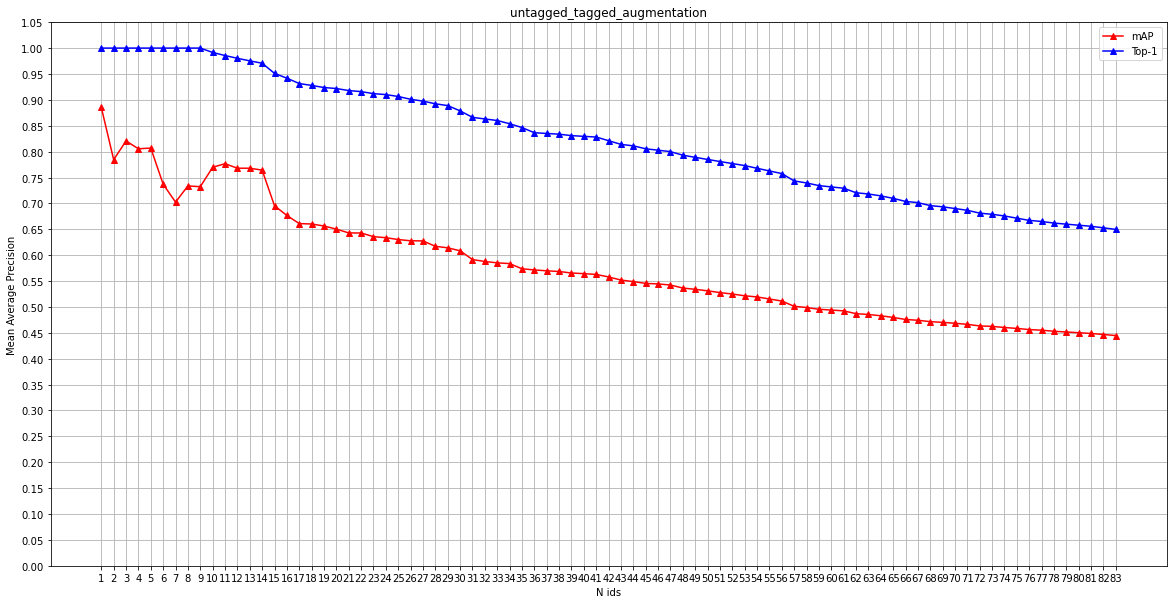

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(nids, NmAPs, "^-r", label="mAP")
plt.plot(nids, top1s, "^-b", label="Top-1")
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.10, 0.05));
plt.xticks(np.arange(1, len(nids) + 1, 1));
plt.xlabel("N ids")
plt.ylabel("Mean Average Precision");
plt.title("untagged_tagged_augmentation")
plt.legend()

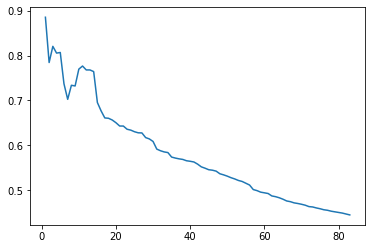

In [13]:
plt.plot(nids, NmAPs)

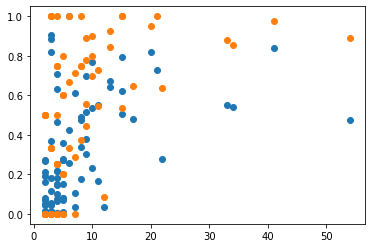

In [14]:
plt.scatter(metrics["n"], metrics["mAP"])
plt.scatter(metrics["n"], metrics["top1"])
# plt.xlim(0, )

In [17]:
# mAPs

In [18]:
def mAP_evaluation_nids(model, Nids, oneimage=False, N=1, timegap=15, timegap_unit="m", batch_size=256):
    test_df = pd.read_csv(EVALUATION_FILES["test"])
#     test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    APs = list()
    
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    queries_num = 0

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        
        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track) | ~is_same_id]
        gids = gallery_df.track_tag_id.unique()
        gids = gids[:Nids + 1]
        if query_row.track_tag_id not in gids:
            gids[0] = query_row.track_tag_id
        gallery_df = gallery_df[gallery_df.track_tag_id.isin(gids)]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
        if oneimage:
            gallery_df = gallery_df.groupby("track_tag_id").sample(1)
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
            
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = tf.matmul(query, gallery.T)
            distances = np.squeeze(distances.numpy())

            binary_labels = (labels == query_id).astype(bool)

            precision, recall, thresholds = precision_recall_curve(binary_labels, distances)

            AP = auc(recall, precision)
            APs.append(AP)
            queries_num += 1
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(APs)

def mAP_evaluation_nid2(model, ids, timegap=15, timegap_unit="m", batch_size=256):
    test_df = pd.read_csv(EVALUATION_FILES["test"])
    test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    APs = list()
    
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    queries_num = 0

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        
        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
            
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = tf.matmul(query, gallery.T)
            distances = np.squeeze(distances.numpy())

            binary_labels = (labels == query_id).astype(bool)

            precision, recall, thresholds = precision_recall_curve(binary_labels, distances)

            AP = auc(recall, precision)
            APs.append(AP)
            queries_num += 1
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(APs)


def topN_evaluation_nids(model, Nids, oneimage=False, N=1, timegap=15, timegap_unit="m", batch_size=256):
    test_df = pd.read_csv(EVALUATION_FILES["test"])
#     test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    ACCs = list()
    
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    queries_num = 0

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        
        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track) | ~is_same_id]
        gids = gallery_df.track_tag_id.unique()
        gids = gids[:Nids + 1]
        if query_row.track_tag_id not in gids:
            gids[0] = query_row.track_tag_id
        gallery_df = gallery_df[gallery_df.track_tag_id.isin(gids)]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
        if oneimage:
            gallery_df = gallery_df.groupby("track_tag_id").sample(1)
            
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = tf.matmul(query, gallery.T)
            distances = np.squeeze(distances.numpy())
#             return distances, labels, query_id
            min_idx = np.argsort(distances)
            
            predicted_ids = labels[min_idx[-N:]]

            acc = np.any(predicted_ids == query_id)
            ACCs.append(acc)
            queries_num += 1
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(ACCs)


def topN_evaluation_nid2(model, ids, N=1, timegap=15, timegap_unit="m", batch_size=256):
    test_df = pd.read_csv(EVALUATION_FILES["test"])
    test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    ACCs = list()
    
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    queries_num = 0

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        
        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track) | ~is_same_id]

        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
            
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = tf.matmul(query, gallery.T)
            distances = np.squeeze(distances.numpy())
#             return distances, labels, query_id
            min_idx = np.argsort(distances)
            
            predicted_ids = labels[min_idx[-N:]]

            acc = np.any(predicted_ids == query_id)
            ACCs.append(acc)
            queries_num += 1
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(ACCs)

In [19]:
sorted_tags_ids = []
for n, i in enumerate(sorted_topN_indx):
    tag_id = metrics["id"][i]
    sorted_tags_ids.append(tag_id)
current_ids = []
nids = list()
mAPs = list()
for i, tid in enumerate(sorted_tags_ids):
    current_ids.append(tid)
    if i == 0:
        current_mAP = 1.0
    else:
        current_mAP = topN_evaluation_nids(base_model, i, oneimage=True)
    mAPs.append(current_mAP)
    nids.append(i+1)

13/13 [==============================] - 1s 84ms/step


  0%|          | 0/654 [00:00<?, ?it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:13<00:00, 49.96it/s]


Evaluating 3173 queries.
13/13 [==============================] - 1s 85ms/step


  0%|          | 0/654 [00:00<?, ?it/s]

Evaluating 654 tracks.


 16%|█▋        | 107/654 [00:02<00:15, 36.14it/s]


KeyboardInterrupt: 

In [23]:
sorted_tags_ids = []
for n, i in enumerate(sorted_mAP_indx):
    tag_id = metrics["id"][i]
    sorted_tags_ids.append(tag_id)
current_ids = []
nids = list()
mAPs = list()
for i, tid in enumerate(sorted_tags_ids):
    current_ids.append(tid)
    if i == 0:
        current_mAP = 1.0
    else:
        current_mAP =  mAP_evaluation_nid2(base_model, current_ids)
    mAPs.append(current_mAP)
    nids.append(i+1)
    
df_dict = {"n": nids, "top1": mAPs}
df = pd.DataFrame(df_dict)
# df.to_csv("mAP_by_n_ideal.csv")

1/1 [==============================] - 0s 2ms/step


100%|██████████| 9/9 [00:00<00:00, 153.71it/s]

Evaluating 9 tracks.
Evaluating 16 queries.


1/1 [==============================] - 0s 2ms/step


100%|██████████| 12/12 [00:00<00:00, 114.59it/s]

Evaluating 12 tracks.
Evaluating 31 queries.


2/2 [==============================] - 0s 146ms/step


 11%|█▏        | 6/53 [00:00<00:00, 51.81it/s]

Evaluating 53 tracks.


100%|██████████| 53/53 [00:01<00:00, 52.54it/s]


Evaluating 509 queries.
2/2 [==============================] - 0s 55ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

Evaluating 56 tracks.


100%|██████████| 56/56 [00:00<00:00, 67.55it/s]


Evaluating 512 queries.
3/3 [==============================] - 0s 85ms/step


  0%|          | 0/76 [00:00<?, ?it/s]

Evaluating 76 tracks.


100%|██████████| 76/76 [00:01<00:00, 58.35it/s]


Evaluating 653 queries.
3/3 [==============================] - 0s 121ms/step


  9%|▉         | 8/91 [00:00<00:01, 74.75it/s]

Evaluating 91 tracks.


100%|██████████| 91/91 [00:01<00:00, 62.51it/s]


Evaluating 738 queries.
3/3 [==============================] - 0s 125ms/step


  8%|▊         | 8/101 [00:00<00:01, 72.04it/s]

Evaluating 101 tracks.


100%|██████████| 101/101 [00:01<00:00, 61.05it/s]


Evaluating 762 queries.
4/4 [==============================] - 0s 54ms/step


  0%|          | 0/122 [00:00<?, ?it/s]

Evaluating 122 tracks.


100%|██████████| 122/122 [00:01<00:00, 81.62it/s] 


Evaluating 831 queries.
4/4 [==============================] - 0s 73ms/step


  0%|          | 0/126 [00:00<?, ?it/s]

Evaluating 126 tracks.


100%|██████████| 126/126 [00:01<00:00, 70.47it/s] 


Evaluating 838 queries.
4/4 [==============================] - 0s 79ms/step


  0%|          | 0/135 [00:00<?, ?it/s]

Evaluating 135 tracks.


100%|██████████| 135/135 [00:01<00:00, 73.49it/s] 


Evaluating 862 queries.
4/4 [==============================] - 0s 101ms/step


  7%|▋         | 10/148 [00:00<00:01, 99.02it/s]

Evaluating 148 tracks.


100%|██████████| 148/148 [00:02<00:00, 70.57it/s]


Evaluating 931 queries.
4/4 [==============================] - 0s 67ms/step


  0%|          | 0/161 [00:00<?, ?it/s]

Evaluating 161 tracks.


100%|██████████| 161/161 [00:01<00:00, 81.99it/s] 


Evaluating 965 queries.
4/4 [==============================] - 0s 69ms/step


  0%|          | 0/165 [00:00<?, ?it/s]

Evaluating 165 tracks.


100%|██████████| 165/165 [00:02<00:00, 81.40it/s] 


Evaluating 1006 queries.
5/5 [==============================] - 0s 60ms/step


  0%|          | 0/180 [00:00<?, ?it/s]

Evaluating 180 tracks.


100%|██████████| 180/180 [00:02<00:00, 73.35it/s] 


Evaluating 1047 queries.
5/5 [==============================] - 0s 77ms/step


  0%|          | 0/187 [00:00<?, ?it/s]

Evaluating 187 tracks.


100%|██████████| 187/187 [00:02<00:00, 75.28it/s] 


Evaluating 1083 queries.
5/5 [==============================] - 0s 83ms/step


  0%|          | 0/198 [00:00<?, ?it/s]

Evaluating 198 tracks.


100%|██████████| 198/198 [00:03<00:00, 58.94it/s]


Evaluating 1117 queries.
6/6 [==============================] - 1s 101ms/step


  4%|▍         | 10/231 [00:00<00:02, 99.69it/s]

Evaluating 231 tracks.


100%|██████████| 231/231 [00:03<00:00, 60.57it/s]


Evaluating 1458 queries.
7/7 [==============================] - 1s 77ms/step


  0%|          | 0/265 [00:00<?, ?it/s]

Evaluating 265 tracks.


100%|██████████| 265/265 [00:04<00:00, 55.50it/s]


Evaluating 1723 queries.
7/7 [==============================] - 1s 101ms/step


  3%|▎         | 9/275 [00:00<00:03, 84.84it/s]

Evaluating 275 tracks.


100%|██████████| 275/275 [00:04<00:00, 56.72it/s]


Evaluating 1761 queries.
7/7 [==============================] - 1s 104ms/step


  4%|▍         | 11/284 [00:00<00:02, 109.82it/s]

Evaluating 284 tracks.


100%|██████████| 284/284 [00:04<00:00, 62.47it/s]


Evaluating 1785 queries.
8/8 [==============================] - 1s 84ms/step


  0%|          | 0/299 [00:00<?, ?it/s]

Evaluating 299 tracks.


100%|██████████| 299/299 [00:07<00:00, 38.74it/s]


Evaluating 1918 queries.
8/8 [==============================] - 1s 93ms/step


  4%|▎         | 11/307 [00:00<00:02, 103.14it/s]

Evaluating 307 tracks.


100%|██████████| 307/307 [00:05<00:00, 59.40it/s]


Evaluating 1945 queries.
8/8 [==============================] - 1s 81ms/step


  0%|          | 0/324 [00:00<?, ?it/s]

Evaluating 324 tracks.


100%|██████████| 324/324 [00:05<00:00, 56.41it/s]


Evaluating 2027 queries.
9/9 [==============================] - 1s 75ms/step


  0%|          | 0/378 [00:00<?, ?it/s]

Evaluating 378 tracks.


100%|██████████| 378/378 [00:06<00:00, 58.36it/s]


Evaluating 2196 queries.
9/9 [==============================] - 1s 77ms/step


  0%|          | 0/386 [00:00<?, ?it/s]

Evaluating 386 tracks.


100%|██████████| 386/386 [00:07<00:00, 52.15it/s]


Evaluating 2223 queries.
9/9 [==============================] - 1s 96ms/step


  2%|▏         | 9/390 [00:00<00:04, 88.96it/s]

Evaluating 390 tracks.


100%|██████████| 390/390 [00:07<00:00, 50.41it/s]


Evaluating 2230 queries.
10/10 [==============================] - 1s 75ms/step


  0%|          | 0/396 [00:00<?, ?it/s]

Evaluating 396 tracks.


100%|██████████| 396/396 [00:07<00:00, 56.04it/s]


Evaluating 2335 queries.
10/10 [==============================] - 1s 77ms/step


  0%|          | 0/405 [00:00<?, ?it/s]

Evaluating 405 tracks.


100%|██████████| 405/405 [00:07<00:00, 55.54it/s]


Evaluating 2402 queries.
10/10 [==============================] - 1s 86ms/step


  0%|          | 0/408 [00:00<?, ?it/s]

Evaluating 408 tracks.


100%|██████████| 408/408 [00:07<00:00, 54.87it/s]


Evaluating 2406 queries.
10/10 [==============================] - 1s 77ms/step


  0%|          | 0/413 [00:00<?, ?it/s]

Evaluating 413 tracks.


100%|██████████| 413/413 [00:07<00:00, 55.01it/s]


Evaluating 2422 queries.
10/10 [==============================] - 1s 78ms/step


  0%|          | 0/421 [00:00<?, ?it/s]

Evaluating 421 tracks.


100%|██████████| 421/421 [00:07<00:00, 53.74it/s]


Evaluating 2466 queries.
10/10 [==============================] - 1s 98ms/step


  3%|▎         | 13/430 [00:00<00:03, 124.06it/s]

Evaluating 430 tracks.


100%|██████████| 430/430 [00:07<00:00, 55.69it/s]


Evaluating 2497 queries.
11/11 [==============================] - 1s 81ms/step


  0%|          | 0/452 [00:00<?, ?it/s]

Evaluating 452 tracks.


100%|██████████| 452/452 [00:08<00:00, 54.31it/s]


Evaluating 2597 queries.
11/11 [==============================] - 1s 76ms/step


  0%|          | 0/457 [00:00<?, ?it/s]

Evaluating 457 tracks.


100%|██████████| 457/457 [00:08<00:00, 51.52it/s]


Evaluating 2608 queries.
11/11 [==============================] - 1s 81ms/step


  0%|          | 0/459 [00:00<?, ?it/s]

Evaluating 459 tracks.


100%|██████████| 459/459 [00:08<00:00, 53.26it/s]


Evaluating 2612 queries.
11/11 [==============================] - 1s 83ms/step


  0%|          | 0/464 [00:00<?, ?it/s]

Evaluating 464 tracks.


100%|██████████| 464/464 [00:08<00:00, 55.04it/s]


Evaluating 2635 queries.
11/11 [==============================] - 1s 77ms/step


  0%|          | 0/469 [00:00<?, ?it/s]

Evaluating 469 tracks.


100%|██████████| 469/469 [00:09<00:00, 51.35it/s]


Evaluating 2653 queries.
11/11 [==============================] - 1s 84ms/step


  0%|          | 0/471 [00:00<?, ?it/s]

Evaluating 471 tracks.


100%|██████████| 471/471 [00:10<00:00, 46.86it/s]


Evaluating 2657 queries.
11/11 [==============================] - 1s 78ms/step


  0%|          | 0/477 [00:00<?, ?it/s]

Evaluating 477 tracks.


100%|██████████| 477/477 [00:08<00:00, 54.59it/s]


Evaluating 2675 queries.
11/11 [==============================] - 1s 90ms/step


  2%|▏         | 9/487 [00:00<00:05, 89.08it/s]

Evaluating 487 tracks.


100%|██████████| 487/487 [00:09<00:00, 50.76it/s]


Evaluating 2720 queries.
11/11 [==============================] - 1s 82ms/step


  0%|          | 0/491 [00:00<?, ?it/s]

Evaluating 491 tracks.


100%|██████████| 491/491 [00:09<00:00, 53.28it/s]


Evaluating 2754 queries.
11/11 [==============================] - 1s 82ms/step


  0%|          | 0/495 [00:00<?, ?it/s]

Evaluating 495 tracks.


100%|██████████| 495/495 [00:09<00:00, 50.68it/s]


Evaluating 2766 queries.
11/11 [==============================] - 1s 101ms/step


  3%|▎         | 15/497 [00:00<00:03, 141.76it/s]

Evaluating 497 tracks.


100%|██████████| 497/497 [00:09<00:00, 52.11it/s]


Evaluating 2776 queries.
11/11 [==============================] - 1s 82ms/step


  0%|          | 0/499 [00:00<?, ?it/s]

Evaluating 499 tracks.


100%|██████████| 499/499 [00:09<00:00, 52.96it/s]


Evaluating 2785 queries.
11/11 [==============================] - 1s 82ms/step


  0%|          | 0/503 [00:00<?, ?it/s]

Evaluating 503 tracks.


100%|██████████| 503/503 [00:09<00:00, 50.76it/s]


Evaluating 2789 queries.
11/11 [==============================] - 1s 82ms/step


  0%|          | 0/506 [00:00<?, ?it/s]

Evaluating 506 tracks.


100%|██████████| 506/506 [00:09<00:00, 51.70it/s]


Evaluating 2794 queries.
11/11 [==============================] - 1s 83ms/step


  0%|          | 0/514 [00:00<?, ?it/s]

Evaluating 514 tracks.


100%|██████████| 514/514 [00:09<00:00, 52.97it/s]


Evaluating 2812 queries.
12/12 [==============================] - 1s 79ms/step


  0%|          | 0/525 [00:00<?, ?it/s]

Evaluating 525 tracks.


100%|██████████| 525/525 [00:10<00:00, 51.78it/s]


Evaluating 2835 queries.
12/12 [==============================] - 1s 77ms/step


  0%|          | 0/527 [00:00<?, ?it/s]

Evaluating 527 tracks.


100%|██████████| 527/527 [00:10<00:00, 51.98it/s]


Evaluating 2870 queries.
12/12 [==============================] - 1s 85ms/step


  0%|          | 0/531 [00:00<?, ?it/s]

Evaluating 531 tracks.


100%|██████████| 531/531 [00:09<00:00, 54.00it/s]


Evaluating 2908 queries.
12/12 [==============================] - 1s 78ms/step


  0%|          | 0/536 [00:00<?, ?it/s]

Evaluating 536 tracks.


100%|██████████| 536/536 [00:11<00:00, 48.05it/s]


Evaluating 2918 queries.
12/12 [==============================] - 1s 85ms/step


  0%|          | 0/540 [00:00<?, ?it/s]

Evaluating 540 tracks.


100%|██████████| 540/540 [00:10<00:00, 50.59it/s]


Evaluating 2924 queries.
12/12 [==============================] - 1s 86ms/step


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluating 543 tracks.


100%|██████████| 543/543 [00:10<00:00, 52.60it/s]


Evaluating 2932 queries.
12/12 [==============================] - 1s 88ms/step


  0%|          | 0/550 [00:00<?, ?it/s]

Evaluating 550 tracks.


100%|██████████| 550/550 [00:09<00:00, 56.41it/s]


Evaluating 2947 queries.
12/12 [==============================] - 1s 80ms/step


  0%|          | 0/554 [00:00<?, ?it/s]

Evaluating 554 tracks.


100%|██████████| 554/554 [00:10<00:00, 54.70it/s]


Evaluating 2957 queries.
12/12 [==============================] - 1s 89ms/step


  2%|▏         | 12/559 [00:00<00:04, 115.57it/s]

Evaluating 559 tracks.


100%|██████████| 559/559 [00:09<00:00, 55.97it/s]


Evaluating 2965 queries.
12/12 [==============================] - 1s 90ms/step


  2%|▏         | 10/561 [00:00<00:05, 94.25it/s]

Evaluating 561 tracks.


100%|██████████| 561/561 [00:09<00:00, 56.97it/s]


Evaluating 2968 queries.
12/12 [==============================] - 1s 94ms/step


  2%|▏         | 10/566 [00:00<00:05, 97.15it/s]

Evaluating 566 tracks.


100%|██████████| 566/566 [00:10<00:00, 56.18it/s]


Evaluating 2977 queries.
12/12 [==============================] - 1s 95ms/step


  3%|▎         | 15/570 [00:00<00:03, 140.86it/s]

Evaluating 570 tracks.


100%|██████████| 570/570 [00:11<00:00, 49.76it/s]


Evaluating 2983 queries.
12/12 [==============================] - 1s 93ms/step


  2%|▏         | 13/572 [00:00<00:04, 122.11it/s]

Evaluating 572 tracks.


100%|██████████| 572/572 [00:10<00:00, 55.60it/s]


Evaluating 2989 queries.
12/12 [==============================] - 1s 81ms/step


  0%|          | 0/577 [00:00<?, ?it/s]

Evaluating 577 tracks.


100%|██████████| 577/577 [00:10<00:00, 53.92it/s]


Evaluating 2996 queries.
12/12 [==============================] - 1s 95ms/step


  1%|          | 7/581 [00:00<00:08, 65.80it/s]

Evaluating 581 tracks.


100%|██████████| 581/581 [00:12<00:00, 46.92it/s]


Evaluating 3004 queries.
12/12 [==============================] - 1s 81ms/step


  0%|          | 0/584 [00:00<?, ?it/s]

Evaluating 584 tracks.


100%|██████████| 584/584 [00:10<00:00, 53.25it/s]


Evaluating 3009 queries.
12/12 [==============================] - 1s 97ms/step


  2%|▏         | 10/586 [00:00<00:06, 95.76it/s]

Evaluating 586 tracks.


100%|██████████| 586/586 [00:11<00:00, 49.12it/s]


Evaluating 3017 queries.
12/12 [==============================] - 1s 99ms/step


  2%|▏         | 14/589 [00:00<00:04, 129.26it/s]

Evaluating 589 tracks.


100%|██████████| 589/589 [00:10<00:00, 53.94it/s]


Evaluating 3033 queries.
12/12 [==============================] - 1s 83ms/step


  0%|          | 0/591 [00:00<?, ?it/s]

Evaluating 591 tracks.


100%|██████████| 591/591 [00:11<00:00, 51.84it/s]


Evaluating 3035 queries.
12/12 [==============================] - 1s 84ms/step


  0%|          | 0/594 [00:00<?, ?it/s]

Evaluating 594 tracks.


100%|██████████| 594/594 [00:10<00:00, 54.07it/s]


Evaluating 3042 queries.
12/12 [==============================] - 1s 99ms/step


  1%|▏         | 9/601 [00:00<00:06, 89.70it/s]

Evaluating 601 tracks.


100%|██████████| 601/601 [00:11<00:00, 53.79it/s]


Evaluating 3062 queries.
13/13 [==============================] - 1s 79ms/step


  0%|          | 0/613 [00:00<?, ?it/s]

Evaluating 613 tracks.


100%|██████████| 613/613 [00:11<00:00, 53.75it/s]


Evaluating 3099 queries.
13/13 [==============================] - 1s 81ms/step


  0%|          | 0/615 [00:00<?, ?it/s]

Evaluating 615 tracks.


100%|██████████| 615/615 [00:12<00:00, 48.97it/s]


Evaluating 3101 queries.
13/13 [==============================] - 1s 83ms/step


  0%|          | 0/618 [00:00<?, ?it/s]

Evaluating 618 tracks.


100%|██████████| 618/618 [00:12<00:00, 51.25it/s]


Evaluating 3106 queries.
13/13 [==============================] - 1s 78ms/step


  0%|          | 0/621 [00:00<?, ?it/s]

Evaluating 621 tracks.


100%|██████████| 621/621 [00:12<00:00, 50.31it/s]


Evaluating 3109 queries.
13/13 [==============================] - 1s 79ms/step


  0%|          | 0/626 [00:00<?, ?it/s]

Evaluating 626 tracks.


100%|██████████| 626/626 [00:11<00:00, 52.34it/s]


Evaluating 3126 queries.
13/13 [==============================] - 1s 79ms/step


  0%|          | 0/630 [00:00<?, ?it/s]

Evaluating 630 tracks.


100%|██████████| 630/630 [00:12<00:00, 49.08it/s]


Evaluating 3131 queries.
13/13 [==============================] - 1s 84ms/step


  0%|          | 0/633 [00:00<?, ?it/s]

Evaluating 633 tracks.


100%|██████████| 633/633 [00:12<00:00, 52.69it/s]


Evaluating 3137 queries.
13/13 [==============================] - 1s 79ms/step


  0%|          | 0/637 [00:00<?, ?it/s]

Evaluating 637 tracks.


100%|██████████| 637/637 [00:11<00:00, 55.53it/s]


Evaluating 3144 queries.
13/13 [==============================] - 1s 78ms/step


  0%|          | 0/640 [00:00<?, ?it/s]

Evaluating 640 tracks.


100%|██████████| 640/640 [00:10<00:00, 60.31it/s]


Evaluating 3147 queries.
13/13 [==============================] - 1s 86ms/step


  0%|          | 0/642 [00:00<?, ?it/s]

Evaluating 642 tracks.


100%|██████████| 642/642 [00:11<00:00, 56.38it/s]


Evaluating 3153 queries.
13/13 [==============================] - 1s 85ms/step


  0%|          | 0/644 [00:00<?, ?it/s]

Evaluating 644 tracks.


100%|██████████| 644/644 [00:11<00:00, 54.80it/s]


Evaluating 3162 queries.
13/13 [==============================] - 1s 80ms/step


  0%|          | 0/646 [00:00<?, ?it/s]

Evaluating 646 tracks.


100%|██████████| 646/646 [00:11<00:00, 56.53it/s]


Evaluating 3164 queries.
13/13 [==============================] - 1s 86ms/step


  0%|          | 0/649 [00:00<?, ?it/s]

Evaluating 649 tracks.


100%|██████████| 649/649 [00:11<00:00, 56.08it/s]


Evaluating 3171 queries.
13/13 [==============================] - 1s 79ms/step


  0%|          | 0/651 [00:00<?, ?it/s]

Evaluating 651 tracks.


100%|██████████| 651/651 [00:11<00:00, 55.47it/s]

Evaluating 3173 queries.


In [22]:
sorted_tags_ids = []
for n, i in enumerate(sorted_mAP_indx):
    tag_id = metrics["id"][i]
    sorted_tags_ids.append(tag_id)
current_ids = []
nids = list()
mAPs = list()
for i, tid in enumerate(sorted_tags_ids):
    if i == 0:
        current_mAP = 1.0
    else:
        current_mAP = mAP_evaluation_nids(base_model, i, oneimage=False)
    mAPs.append(current_mAP)
    nids.append(i+1)
    
df_dict = {"n": nids, "top1": mAPs}
df = pd.DataFrame(df_dict)
# df.to_csv("mAP_by_n_ideal.csv")

13/13 [==============================] - 1s 102ms/step


  0%|          | 0/654 [00:00<?, ?it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:06<00:00, 101.72it/s]


Evaluating 3173 queries.
13/13 [==============================] - 1s 82ms/step


  0%|          | 0/654 [00:00<?, ?it/s]

Evaluating 654 tracks.


 41%|████      | 269/654 [00:02<00:04, 93.35it/s] 


KeyboardInterrupt: 

In [ ]:
df

In [12]:
sorted_tags_ids = []
for n, i in enumerate(sorted_topN_indx):
    tag_id = metrics["id"][i]
    sorted_tags_ids.append(tag_id)
current_ids = []
nids = list()
mAPs = list()
for i, tid in enumerate(sorted_tags_ids):
    current_ids.append(tid)
    if i == 0:
        current_mAP = 1.0
    else:
        current_mAP = topN_evaluation_nid2(base_model, current_ids)
    mAPs.append(current_mAP)
    nids.append(i+1)

1/1 [==============================] - 0s 2ms/step


100%|██████████| 7/7 [00:00<00:00, 108.01it/s]

Evaluating 7 tracks.
Evaluating 22 queries.


1/1 [==============================] - 0s 2ms/step


100%|██████████| 10/10 [00:00<00:00, 163.95it/s]

Evaluating 10 tracks.
Evaluating 27 queries.


1/1 [==============================] - 0s 2ms/step


 40%|████      | 10/25 [00:00<00:00, 96.12it/s]

Evaluating 25 tracks.


100%|██████████| 25/25 [00:00<00:00, 97.96it/s]


Evaluating 112 queries.
1/1 [==============================] - 0s 2ms/step


 46%|████▋     | 13/28 [00:00<00:00, 127.85it/s]

Evaluating 28 tracks.


100%|██████████| 28/28 [00:00<00:00, 122.57it/s]


Evaluating 115 queries.
1/1 [==============================] - 0s 1ms/step


 36%|███▌      | 13/36 [00:00<00:00, 122.48it/s]

Evaluating 36 tracks.


100%|██████████| 36/36 [00:00<00:00, 124.42it/s]


Evaluating 142 queries.
1/1 [==============================] - 0s 2ms/step


 25%|██▌       | 13/51 [00:00<00:00, 126.17it/s]

Evaluating 51 tracks.


100%|██████████| 51/51 [00:00<00:00, 129.82it/s]


Evaluating 183 queries.
1/1 [==============================] - 0s 2ms/step


 23%|██▎       | 13/57 [00:00<00:00, 124.02it/s]

Evaluating 57 tracks.


100%|██████████| 57/57 [00:00<00:00, 137.75it/s]


Evaluating 194 queries.
2/2 [==============================] - 0s 27ms/step


 17%|█▋        | 13/78 [00:00<00:00, 129.71it/s]

Evaluating 78 tracks.


100%|██████████| 78/78 [00:00<00:00, 142.46it/s]


Evaluating 263 queries.
3/3 [==============================] - 0s 118ms/step


 11%|█         | 13/119 [00:00<00:00, 110.37it/s]

Evaluating 119 tracks.


100%|██████████| 119/119 [00:01<00:00, 98.96it/s] 


Evaluating 741 queries.
4/4 [==============================] - 0s 81ms/step


  0%|          | 0/139 [00:00<?, ?it/s]

Evaluating 139 tracks.


100%|██████████| 139/139 [00:01<00:00, 96.45it/s] 


Evaluating 882 queries.
4/4 [==============================] - 0s 67ms/step


  0%|          | 0/152 [00:00<?, ?it/s]

Evaluating 152 tracks.


100%|██████████| 152/152 [00:01<00:00, 109.47it/s]


Evaluating 951 queries.
4/4 [==============================] - 1s 128ms/step


 10%|▉         | 16/162 [00:00<00:00, 158.06it/s]

Evaluating 162 tracks.


100%|██████████| 162/162 [00:01<00:00, 101.19it/s]


Evaluating 975 queries.
4/4 [==============================] - 0s 116ms/step


  6%|▋         | 11/171 [00:00<00:01, 106.34it/s]

Evaluating 171 tracks.


100%|██████████| 171/171 [00:01<00:00, 86.10it/s] 


Evaluating 999 queries.
5/5 [==============================] - 0s 90ms/step


  0%|          | 0/225 [00:00<?, ?it/s]

Evaluating 225 tracks.


100%|██████████| 225/225 [00:02<00:00, 84.55it/s] 


Evaluating 1168 queries.
6/6 [==============================] - 0s 81ms/step


  0%|          | 0/258 [00:00<?, ?it/s]

Evaluating 258 tracks.


100%|██████████| 258/258 [00:03<00:00, 81.25it/s] 


Evaluating 1509 queries.
7/7 [==============================] - 1s 105ms/step


  5%|▌         | 16/292 [00:00<00:01, 152.56it/s]

Evaluating 292 tracks.


100%|██████████| 292/292 [00:03<00:00, 73.21it/s]


Evaluating 1774 queries.
8/8 [==============================] - 1s 74ms/step


  0%|          | 0/305 [00:00<?, ?it/s]

Evaluating 305 tracks.


100%|██████████| 305/305 [00:04<00:00, 70.42it/s] 


Evaluating 1808 queries.
8/8 [==============================] - 1s 80ms/step


  0%|          | 0/315 [00:00<?, ?it/s]

Evaluating 315 tracks.


100%|██████████| 315/315 [00:03<00:00, 81.37it/s] 


Evaluating 1846 queries.
8/8 [==============================] - 1s 83ms/step


  0%|          | 0/320 [00:00<?, ?it/s]

Evaluating 320 tracks.


100%|██████████| 320/320 [00:04<00:00, 77.79it/s] 


Evaluating 1864 queries.
8/8 [==============================] - 1s 88ms/step


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluating 329 tracks.


100%|██████████| 329/329 [00:04<00:00, 78.20it/s]


Evaluating 1931 queries.
8/8 [==============================] - 1s 99ms/step


  5%|▍         | 15/333 [00:00<00:02, 143.46it/s]

Evaluating 333 tracks.


100%|██████████| 333/333 [00:04<00:00, 80.65it/s] 


Evaluating 1972 queries.
8/8 [==============================] - 1s 100ms/step


  3%|▎         | 11/341 [00:00<00:03, 107.15it/s]

Evaluating 341 tracks.


100%|██████████| 341/341 [00:04<00:00, 74.89it/s]


Evaluating 2016 queries.
8/8 [==============================] - 1s 81ms/step


  0%|          | 0/345 [00:00<?, ?it/s]

Evaluating 345 tracks.


100%|██████████| 345/345 [00:03<00:00, 86.58it/s] 


Evaluating 2023 queries.
9/9 [==============================] - 1s 75ms/step


  0%|          | 0/353 [00:00<?, ?it/s]

Evaluating 353 tracks.


100%|██████████| 353/353 [00:04<00:00, 83.60it/s] 


Evaluating 2050 queries.
9/9 [==============================] - 1s 78ms/step


  0%|          | 0/364 [00:00<?, ?it/s]

Evaluating 364 tracks.


100%|██████████| 364/364 [00:04<00:00, 79.44it/s] 


Evaluating 2084 queries.
9/9 [==============================] - 1s 74ms/step


  0%|          | 0/371 [00:00<?, ?it/s]

Evaluating 371 tracks.


100%|██████████| 371/371 [00:04<00:00, 79.70it/s] 


Evaluating 2120 queries.
9/9 [==============================] - 1s 86ms/step


  0%|          | 0/381 [00:00<?, ?it/s]

Evaluating 381 tracks.


100%|██████████| 381/381 [00:04<00:00, 79.73it/s] 


Evaluating 2165 queries.
9/9 [==============================] - 1s 101ms/step


  3%|▎         | 12/387 [00:00<00:03, 118.51it/s]

Evaluating 387 tracks.


100%|██████████| 387/387 [00:05<00:00, 75.05it/s] 


Evaluating 2270 queries.
10/10 [==============================] - 1s 80ms/step


  0%|          | 0/404 [00:00<?, ?it/s]

Evaluating 404 tracks.


100%|██████████| 404/404 [00:06<00:00, 64.37it/s] 


Evaluating 2352 queries.
10/10 [==============================] - 1s 90ms/step


  0%|          | 0/426 [00:00<?, ?it/s]

Evaluating 426 tracks.


100%|██████████| 426/426 [00:05<00:00, 72.15it/s] 


Evaluating 2452 queries.
10/10 [==============================] - 1s 94ms/step


  3%|▎         | 11/431 [00:00<00:03, 107.10it/s]

Evaluating 431 tracks.


100%|██████████| 431/431 [00:05<00:00, 75.57it/s] 


Evaluating 2475 queries.
10/10 [==============================] - 1s 97ms/step


  3%|▎         | 11/436 [00:00<00:04, 104.80it/s]

Evaluating 436 tracks.


100%|██████████| 436/436 [00:06<00:00, 72.44it/s] 


Evaluating 2491 queries.
10/10 [==============================] - 1s 98ms/step


  2%|▏         | 10/445 [00:00<00:04, 98.74it/s]

Evaluating 445 tracks.


100%|██████████| 445/445 [00:06<00:00, 71.30it/s]


Evaluating 2515 queries.
10/10 [==============================] - 1s 98ms/step


  2%|▏         | 10/456 [00:00<00:04, 98.26it/s]

Evaluating 456 tracks.


100%|██████████| 456/456 [00:06<00:00, 73.45it/s] 


Evaluating 2538 queries.
11/11 [==============================] - 1s 89ms/step


  0%|          | 0/471 [00:00<?, ?it/s]

Evaluating 471 tracks.


100%|██████████| 471/471 [00:06<00:00, 69.41it/s]


Evaluating 2671 queries.
11/11 [==============================] - 1s 90ms/step


  4%|▎         | 17/473 [00:00<00:02, 155.63it/s]

Evaluating 473 tracks.


100%|██████████| 473/473 [00:06<00:00, 68.18it/s]


Evaluating 2706 queries.
11/11 [==============================] - 1s 89ms/step


  2%|▏         | 9/475 [00:00<00:05, 88.30it/s]

Evaluating 475 tracks.


100%|██████████| 475/475 [00:07<00:00, 67.15it/s] 


Evaluating 2710 queries.
11/11 [==============================] - 1s 95ms/step


  4%|▎         | 17/479 [00:00<00:03, 152.09it/s]

Evaluating 479 tracks.


100%|██████████| 479/479 [00:06<00:00, 68.77it/s] 


Evaluating 2722 queries.
11/11 [==============================] - 1s 97ms/step


  2%|▏         | 10/481 [00:00<00:05, 93.00it/s]

Evaluating 481 tracks.


100%|██████████| 481/481 [00:07<00:00, 67.44it/s]


Evaluating 2726 queries.
11/11 [==============================] - 1s 94ms/step


  2%|▏         | 11/483 [00:00<00:04, 109.08it/s]

Evaluating 483 tracks.


100%|██████████| 483/483 [00:06<00:00, 70.31it/s] 


Evaluating 2735 queries.
11/11 [==============================] - 1s 99ms/step


  2%|▏         | 11/492 [00:00<00:04, 107.56it/s]

Evaluating 492 tracks.


100%|██████████| 492/492 [00:06<00:00, 71.44it/s] 


Evaluating 2766 queries.
11/11 [==============================] - 1s 83ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating 500 tracks.


100%|██████████| 500/500 [00:06<00:00, 72.43it/s] 


Evaluating 2784 queries.
11/11 [==============================] - 1s 98ms/step


  3%|▎         | 14/503 [00:00<00:03, 135.71it/s]

Evaluating 503 tracks.


100%|██████████| 503/503 [00:07<00:00, 71.52it/s] 


Evaluating 2800 queries.
12/12 [==============================] - 1s 76ms/step


  0%|          | 0/509 [00:00<?, ?it/s]

Evaluating 509 tracks.


100%|██████████| 509/509 [00:07<00:00, 70.08it/s] 


Evaluating 2818 queries.
12/12 [==============================] - 1s 79ms/step


  0%|          | 0/512 [00:00<?, ?it/s]

Evaluating 512 tracks.


100%|██████████| 512/512 [00:07<00:00, 68.84it/s]


Evaluating 2822 queries.
12/12 [==============================] - 1s 80ms/step


  0%|          | 0/515 [00:00<?, ?it/s]

Evaluating 515 tracks.


100%|██████████| 515/515 [00:07<00:00, 69.61it/s]


Evaluating 2827 queries.
12/12 [==============================] - 1s 80ms/step


  0%|          | 0/522 [00:00<?, ?it/s]

Evaluating 522 tracks.


100%|██████████| 522/522 [00:07<00:00, 71.95it/s] 


Evaluating 2842 queries.
12/12 [==============================] - 1s 85ms/step


  0%|          | 0/526 [00:00<?, ?it/s]

Evaluating 526 tracks.


100%|██████████| 526/526 [00:07<00:00, 72.28it/s] 


Evaluating 2876 queries.
12/12 [==============================] - 1s 84ms/step


  0%|          | 0/530 [00:00<?, ?it/s]

Evaluating 530 tracks.


100%|██████████| 530/530 [00:07<00:00, 67.62it/s] 


Evaluating 2882 queries.
12/12 [==============================] - 1s 77ms/step


  0%|          | 0/534 [00:00<?, ?it/s]

Evaluating 534 tracks.


100%|██████████| 534/534 [00:08<00:00, 66.54it/s]


Evaluating 2888 queries.
12/12 [==============================] - 1s 87ms/step


  0%|          | 0/538 [00:00<?, ?it/s]

Evaluating 538 tracks.


100%|██████████| 538/538 [00:07<00:00, 67.63it/s]


Evaluating 2926 queries.
12/12 [==============================] - 1s 87ms/step


  0%|          | 0/542 [00:00<?, ?it/s]

Evaluating 542 tracks.


100%|██████████| 542/542 [00:07<00:00, 69.09it/s]


Evaluating 2934 queries.
12/12 [==============================] - 1s 87ms/step


  0%|          | 0/547 [00:00<?, ?it/s]

Evaluating 547 tracks.


100%|██████████| 547/547 [00:08<00:00, 62.53it/s] 


Evaluating 2945 queries.
12/12 [==============================] - 1s 88ms/step


  0%|          | 0/552 [00:00<?, ?it/s]

Evaluating 552 tracks.


100%|██████████| 552/552 [00:07<00:00, 69.49it/s]


Evaluating 2953 queries.
12/12 [==============================] - 1s 79ms/step


  0%|          | 0/557 [00:00<?, ?it/s]

Evaluating 557 tracks.


100%|██████████| 557/557 [00:07<00:00, 71.00it/s] 


Evaluating 2960 queries.
12/12 [==============================] - 1s 96ms/step


  2%|▏         | 10/569 [00:00<00:05, 98.05it/s]

Evaluating 569 tracks.


100%|██████████| 569/569 [00:08<00:00, 69.01it/s] 


Evaluating 2997 queries.
12/12 [==============================] - 1s 94ms/step


  3%|▎         | 15/572 [00:00<00:03, 146.12it/s]

Evaluating 572 tracks.


100%|██████████| 572/572 [00:09<00:00, 63.11it/s]


Evaluating 3002 queries.
12/12 [==============================] - 1s 95ms/step


  2%|▏         | 12/576 [00:00<00:04, 115.18it/s]

Evaluating 576 tracks.


100%|██████████| 576/576 [00:13<00:00, 42.73it/s]


Evaluating 3007 queries.
12/12 [==============================] - 1s 96ms/step


  1%|▏         | 8/578 [00:00<00:07, 79.80it/s]

Evaluating 578 tracks.


100%|██████████| 578/578 [00:12<00:00, 46.95it/s]


Evaluating 3013 queries.
12/12 [==============================] - 1s 97ms/step


  1%|▏         | 8/580 [00:00<00:07, 73.27it/s]

Evaluating 580 tracks.


100%|██████████| 580/580 [00:10<00:00, 56.49it/s]


Evaluating 3015 queries.
12/12 [==============================] - 1s 98ms/step


  2%|▏         | 10/587 [00:00<00:06, 93.04it/s]

Evaluating 587 tracks.


100%|██████████| 587/587 [00:09<00:00, 60.39it/s]


Evaluating 3035 queries.
12/12 [==============================] - 1s 99ms/step


  2%|▏         | 11/589 [00:00<00:05, 97.88it/s]

Evaluating 589 tracks.


100%|██████████| 589/589 [00:09<00:00, 65.23it/s]


Evaluating 3037 queries.
12/12 [==============================] - 1s 96ms/step


  2%|▏         | 10/592 [00:00<00:06, 91.34it/s]

Evaluating 592 tracks.


100%|██████████| 592/592 [00:09<00:00, 62.88it/s]


Evaluating 3044 queries.
12/12 [==============================] - 1s 99ms/step


  2%|▏         | 11/596 [00:00<00:05, 100.88it/s]

Evaluating 596 tracks.


100%|██████████| 596/596 [00:09<00:00, 63.39it/s]


Evaluating 3051 queries.
12/12 [==============================] - 1s 97ms/step


  1%|▏         | 9/601 [00:00<00:06, 86.88it/s]

Evaluating 601 tracks.


100%|██████████| 601/601 [00:09<00:00, 64.43it/s]


Evaluating 3068 queries.
13/13 [==============================] - 1s 80ms/step


  0%|          | 0/603 [00:00<?, ?it/s]

Evaluating 603 tracks.


100%|██████████| 603/603 [00:11<00:00, 53.97it/s]


Evaluating 3077 queries.
13/13 [==============================] - 1s 80ms/step


  0%|          | 0/608 [00:00<?, ?it/s]

Evaluating 608 tracks.


100%|██████████| 608/608 [00:10<00:00, 60.75it/s]


Evaluating 3087 queries.
13/13 [==============================] - 1s 80ms/step


  0%|          | 0/610 [00:00<?, ?it/s]

Evaluating 610 tracks.


100%|██████████| 610/610 [00:10<00:00, 59.57it/s]


Evaluating 3095 queries.
13/13 [==============================] - 1s 81ms/step


  0%|          | 0/613 [00:00<?, ?it/s]

Evaluating 613 tracks.


100%|██████████| 613/613 [00:09<00:00, 62.02it/s]


Evaluating 3103 queries.
13/13 [==============================] - 1s 82ms/step


  0%|          | 0/616 [00:00<?, ?it/s]

Evaluating 616 tracks.


100%|██████████| 616/616 [00:10<00:00, 57.49it/s]


Evaluating 3110 queries.
13/13 [==============================] - 1s 81ms/step


  0%|          | 0/621 [00:00<?, ?it/s]

Evaluating 621 tracks.


100%|██████████| 621/621 [00:10<00:00, 60.90it/s]


Evaluating 3119 queries.
13/13 [==============================] - 1s 82ms/step


  0%|          | 0/623 [00:00<?, ?it/s]

Evaluating 623 tracks.


100%|██████████| 623/623 [00:10<00:00, 62.18it/s]


Evaluating 3129 queries.
13/13 [==============================] - 1s 83ms/step


  0%|          | 0/626 [00:00<?, ?it/s]

Evaluating 626 tracks.


100%|██████████| 626/626 [00:10<00:00, 62.08it/s]


Evaluating 3135 queries.
13/13 [==============================] - 1s 85ms/step


  0%|          | 0/630 [00:00<?, ?it/s]

Evaluating 630 tracks.


100%|██████████| 630/630 [00:10<00:00, 61.37it/s]


Evaluating 3139 queries.
13/13 [==============================] - 1s 86ms/step


  0%|          | 0/634 [00:00<?, ?it/s]

Evaluating 634 tracks.


100%|██████████| 634/634 [00:10<00:00, 61.48it/s]


Evaluating 3149 queries.
13/13 [==============================] - 1s 86ms/step


  0%|          | 0/636 [00:00<?, ?it/s]

Evaluating 636 tracks.


100%|██████████| 636/636 [00:15<00:00, 42.17it/s]


Evaluating 3152 queries.
13/13 [==============================] - 1s 85ms/step


  0%|          | 0/639 [00:00<?, ?it/s]

Evaluating 639 tracks.


100%|██████████| 639/639 [00:11<00:00, 58.04it/s]


Evaluating 3157 queries.
13/13 [==============================] - 1s 87ms/step


  0%|          | 0/641 [00:00<?, ?it/s]

Evaluating 641 tracks.


100%|██████████| 641/641 [00:09<00:00, 68.93it/s]


Evaluating 3159 queries.
13/13 [==============================] - 1s 86ms/step


  0%|          | 0/643 [00:00<?, ?it/s]

Evaluating 643 tracks.


100%|██████████| 643/643 [00:09<00:00, 71.03it/s] 


Evaluating 3161 queries.
13/13 [==============================] - 1s 89ms/step


  0%|          | 0/645 [00:00<?, ?it/s]

Evaluating 645 tracks.


100%|██████████| 645/645 [00:09<00:00, 65.71it/s]


Evaluating 3167 queries.
13/13 [==============================] - 1s 84ms/step


  0%|          | 0/648 [00:00<?, ?it/s]

Evaluating 648 tracks.


100%|██████████| 648/648 [00:09<00:00, 70.07it/s]


Evaluating 3170 queries.
13/13 [==============================] - 1s 85ms/step


  0%|          | 0/651 [00:00<?, ?it/s]

Evaluating 651 tracks.


100%|██████████| 651/651 [00:10<00:00, 62.84it/s]

Evaluating 3173 queries.


In [13]:
df_dict = {"n": nids, "top1": mAPs}
df = pd.DataFrame(df_dict)
df.to_csv("top1nids_idela.csv")

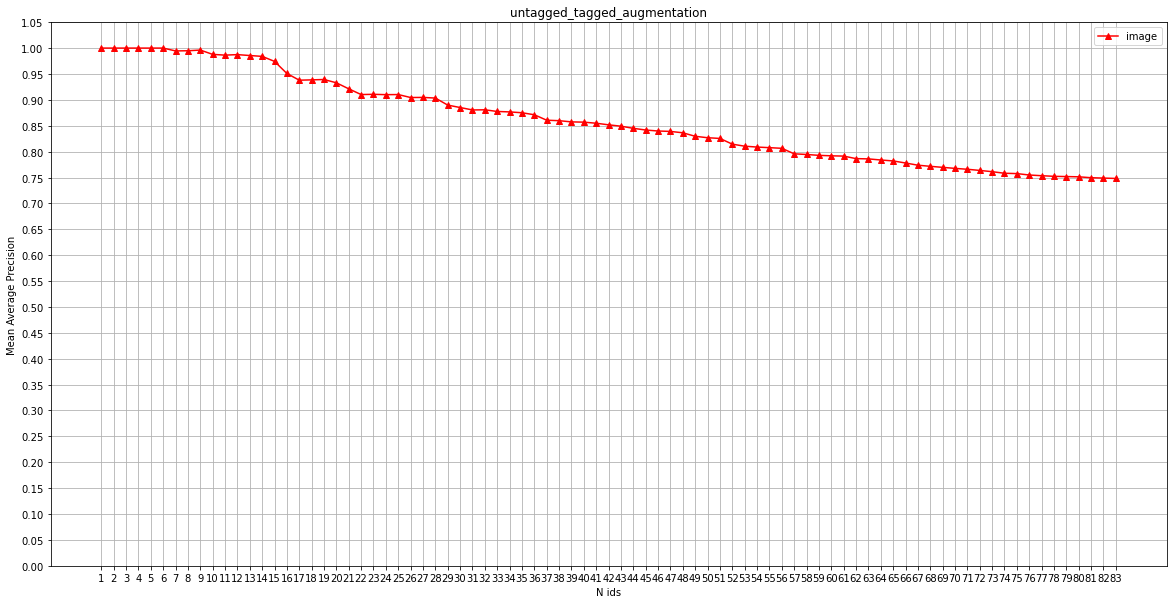

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(nids, mAPs, "^-r", label="image")
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.10, 0.05));
plt.xticks(np.arange(1, len(nids) + 1, 1));
plt.xlabel("N ids")
plt.ylabel("Mean Average Precision");
plt.title("untagged_tagged_augmentation")
plt.legend()
# plt.savefig("topN_by_amount_of_ids.png")

In [9]:
sorted_tags_ids = []
for n, i in enumerate(sorted_mAP_indx):
    tag_id = metrics["id"][i]
    sorted_tags_ids.append(tag_id)

current_ids = []
nids = list()
mAPs = list()
for i, tid in enumerate(sorted_tags_ids):
    current_ids.append(tid)
    if i == 0:
        current_mAP = 1.0
    else:
        current_mAP = mAP_evaluation_nids(base_model, current_ids)
    mAPs.append(current_mAP)
    nids.append(i+1)

1/1 [==============================] - 0s 2ms/step


100%|██████████| 9/9 [00:00<00:00, 148.24it/s]

Evaluating 9 tracks.
Evaluating 16 queries.


1/1 [==============================] - 0s 2ms/step


100%|██████████| 12/12 [00:00<00:00, 105.01it/s]

Evaluating 12 tracks.
Evaluating 31 queries.


2/2 [==============================] - 0s 147ms/step


 11%|█▏        | 6/53 [00:00<00:00, 55.03it/s]

Evaluating 53 tracks.


100%|██████████| 53/53 [00:00<00:00, 54.88it/s]


Evaluating 509 queries.
2/2 [==============================] - 0s 57ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

Evaluating 56 tracks.


100%|██████████| 56/56 [00:00<00:00, 67.03it/s]


Evaluating 512 queries.
3/3 [==============================] - 0s 90ms/step


  0%|          | 0/76 [00:00<?, ?it/s]

Evaluating 76 tracks.


100%|██████████| 76/76 [00:01<00:00, 55.85it/s]


Evaluating 653 queries.
3/3 [==============================] - 0s 117ms/step


  9%|▉         | 8/91 [00:00<00:01, 76.17it/s]

Evaluating 91 tracks.


100%|██████████| 91/91 [00:01<00:00, 59.50it/s]


Evaluating 738 queries.
3/3 [==============================] - 0s 122ms/step


  8%|▊         | 8/101 [00:00<00:01, 67.46it/s]

Evaluating 101 tracks.


100%|██████████| 101/101 [00:01<00:00, 58.22it/s]


Evaluating 762 queries.
4/4 [==============================] - 0s 73ms/step


  0%|          | 0/122 [00:00<?, ?it/s]

Evaluating 122 tracks.


100%|██████████| 122/122 [00:01<00:00, 63.03it/s]


Evaluating 831 queries.
4/4 [==============================] - 0s 73ms/step


  0%|          | 0/126 [00:00<?, ?it/s]

Evaluating 126 tracks.


100%|██████████| 126/126 [00:01<00:00, 72.43it/s] 


Evaluating 838 queries.
4/4 [==============================] - 0s 79ms/step


  0%|          | 0/135 [00:00<?, ?it/s]

Evaluating 135 tracks.


100%|██████████| 135/135 [00:02<00:00, 55.34it/s]


Evaluating 862 queries.
4/4 [==============================] - 0s 103ms/step


  9%|▉         | 14/148 [00:00<00:00, 139.62it/s]

Evaluating 148 tracks.


100%|██████████| 148/148 [00:02<00:00, 56.35it/s]


Evaluating 931 queries.
4/4 [==============================] - 0s 111ms/step


  6%|▌         | 10/161 [00:00<00:01, 92.36it/s]

Evaluating 161 tracks.


100%|██████████| 161/161 [00:03<00:00, 46.86it/s]


Evaluating 965 queries.
4/4 [==============================] - 0s 114ms/step


  6%|▌         | 10/165 [00:00<00:01, 96.71it/s]

Evaluating 165 tracks.


100%|██████████| 165/165 [00:03<00:00, 53.10it/s]


Evaluating 1006 queries.
5/5 [==============================] - 0s 68ms/step


  0%|          | 0/180 [00:00<?, ?it/s]

Evaluating 180 tracks.


100%|██████████| 180/180 [00:03<00:00, 48.96it/s]


Evaluating 1047 queries.
5/5 [==============================] - 0s 76ms/step


  0%|          | 0/187 [00:00<?, ?it/s]

Evaluating 187 tracks.


100%|██████████| 187/187 [00:03<00:00, 60.42it/s]


Evaluating 1083 queries.
5/5 [==============================] - 0s 83ms/step


  0%|          | 0/198 [00:00<?, ?it/s]

Evaluating 198 tracks.


100%|██████████| 198/198 [00:03<00:00, 58.96it/s]


Evaluating 1117 queries.
6/6 [==============================] - 1s 101ms/step


  6%|▌         | 14/231 [00:00<00:02, 105.54it/s]

Evaluating 231 tracks.


100%|██████████| 231/231 [00:03<00:00, 59.19it/s]


Evaluating 1458 queries.
7/7 [==============================] - 1s 98ms/step


  5%|▍         | 12/265 [00:00<00:02, 103.51it/s]

Evaluating 265 tracks.


100%|██████████| 265/265 [00:04<00:00, 54.97it/s]


Evaluating 1723 queries.
7/7 [==============================] - 1s 100ms/step


  4%|▍         | 11/275 [00:00<00:02, 107.03it/s]

Evaluating 275 tracks.


100%|██████████| 275/275 [00:04<00:00, 56.97it/s]


Evaluating 1761 queries.
7/7 [==============================] - 1s 109ms/step


  5%|▍         | 14/284 [00:00<00:02, 110.80it/s]

Evaluating 284 tracks.


100%|██████████| 284/284 [00:04<00:00, 59.58it/s]


Evaluating 1785 queries.
8/8 [==============================] - 1s 86ms/step


  0%|          | 0/299 [00:00<?, ?it/s]

Evaluating 299 tracks.


100%|██████████| 299/299 [00:05<00:00, 57.92it/s]


Evaluating 1918 queries.
8/8 [==============================] - 1s 92ms/step


  4%|▍         | 12/307 [00:00<00:02, 106.04it/s]

Evaluating 307 tracks.


100%|██████████| 307/307 [00:05<00:00, 56.80it/s]


Evaluating 1945 queries.
8/8 [==============================] - 1s 101ms/step


  3%|▎         | 11/324 [00:00<00:03, 103.98it/s]

Evaluating 324 tracks.


100%|██████████| 324/324 [00:05<00:00, 57.16it/s]


Evaluating 2027 queries.
9/9 [==============================] - 1s 89ms/step


  0%|          | 0/378 [00:00<?, ?it/s]

Evaluating 378 tracks.


100%|██████████| 378/378 [00:06<00:00, 58.76it/s]


Evaluating 2196 queries.
9/9 [==============================] - 1s 97ms/step


  3%|▎         | 12/386 [00:00<00:03, 114.10it/s]

Evaluating 386 tracks.


100%|██████████| 386/386 [00:06<00:00, 59.03it/s]


Evaluating 2223 queries.
9/9 [==============================] - 1s 96ms/step


  3%|▎         | 12/390 [00:00<00:03, 115.19it/s]

Evaluating 390 tracks.


100%|██████████| 390/390 [00:06<00:00, 60.33it/s]


Evaluating 2230 queries.
10/10 [==============================] - 1s 77ms/step


  0%|          | 0/396 [00:00<?, ?it/s]

Evaluating 396 tracks.


100%|██████████| 396/396 [00:06<00:00, 56.72it/s]


Evaluating 2335 queries.
10/10 [==============================] - 1s 84ms/step


  0%|          | 0/405 [00:00<?, ?it/s]

Evaluating 405 tracks.


100%|██████████| 405/405 [00:08<00:00, 47.75it/s]


Evaluating 2402 queries.
10/10 [==============================] - 1s 86ms/step


  0%|          | 0/408 [00:00<?, ?it/s]

Evaluating 408 tracks.


100%|██████████| 408/408 [00:07<00:00, 55.33it/s]


Evaluating 2406 queries.
10/10 [==============================] - 1s 85ms/step


  0%|          | 0/413 [00:00<?, ?it/s]

Evaluating 413 tracks.


100%|██████████| 413/413 [00:13<00:00, 30.40it/s]


Evaluating 2422 queries.
10/10 [==============================] - 1s 93ms/step


  4%|▎         | 15/421 [00:00<00:02, 136.15it/s]

Evaluating 421 tracks.


100%|██████████| 421/421 [00:12<00:00, 34.59it/s]


Evaluating 2466 queries.
10/10 [==============================] - 1s 97ms/step


  2%|▏         | 8/430 [00:00<00:05, 75.48it/s]

Evaluating 430 tracks.


100%|██████████| 430/430 [00:09<00:00, 46.89it/s]


Evaluating 2497 queries.
11/11 [==============================] - 1s 82ms/step


  0%|          | 0/452 [00:00<?, ?it/s]

Evaluating 452 tracks.


100%|██████████| 452/452 [00:08<00:00, 56.30it/s]


Evaluating 2597 queries.
11/11 [==============================] - 1s 81ms/step


  0%|          | 0/457 [00:00<?, ?it/s]

Evaluating 457 tracks.


100%|██████████| 457/457 [00:08<00:00, 56.97it/s]


Evaluating 2608 queries.
11/11 [==============================] - 1s 79ms/step


  0%|          | 0/459 [00:00<?, ?it/s]

Evaluating 459 tracks.


100%|██████████| 459/459 [00:08<00:00, 56.99it/s]


Evaluating 2612 queries.
11/11 [==============================] - 1s 84ms/step


  0%|          | 0/464 [00:00<?, ?it/s]

Evaluating 464 tracks.


100%|██████████| 464/464 [00:08<00:00, 57.44it/s]


Evaluating 2635 queries.
11/11 [==============================] - 1s 75ms/step


  0%|          | 0/469 [00:00<?, ?it/s]

Evaluating 469 tracks.


100%|██████████| 469/469 [00:08<00:00, 52.87it/s]


Evaluating 2653 queries.
11/11 [==============================] - 1s 88ms/step


  0%|          | 0/471 [00:00<?, ?it/s]

Evaluating 471 tracks.


100%|██████████| 471/471 [00:08<00:00, 52.56it/s]


Evaluating 2657 queries.
11/11 [==============================] - 1s 85ms/step


  0%|          | 0/477 [00:00<?, ?it/s]

Evaluating 477 tracks.


100%|██████████| 477/477 [00:08<00:00, 56.04it/s]


Evaluating 2675 queries.
11/11 [==============================] - 1s 87ms/step


  3%|▎         | 16/487 [00:00<00:03, 140.70it/s]

Evaluating 487 tracks.


100%|██████████| 487/487 [00:08<00:00, 57.20it/s]


Evaluating 2720 queries.
11/11 [==============================] - 1s 95ms/step


  2%|▏         | 10/491 [00:00<00:05, 96.01it/s]

Evaluating 491 tracks.


100%|██████████| 491/491 [00:08<00:00, 57.07it/s]


Evaluating 2754 queries.
11/11 [==============================] - 1s 97ms/step


  2%|▏         | 9/495 [00:00<00:05, 85.84it/s]

Evaluating 495 tracks.


100%|██████████| 495/495 [00:08<00:00, 57.14it/s]


Evaluating 2766 queries.
11/11 [==============================] - 1s 97ms/step


  3%|▎         | 15/497 [00:00<00:03, 145.34it/s]

Evaluating 497 tracks.


100%|██████████| 497/497 [00:08<00:00, 57.68it/s]


Evaluating 2776 queries.
11/11 [==============================] - 1s 80ms/step


  0%|          | 0/499 [00:00<?, ?it/s]

Evaluating 499 tracks.


100%|██████████| 499/499 [00:09<00:00, 51.32it/s]


Evaluating 2785 queries.
11/11 [==============================] - 1s 96ms/step


  3%|▎         | 15/503 [00:00<00:03, 144.15it/s]

Evaluating 503 tracks.


100%|██████████| 503/503 [00:08<00:00, 56.60it/s]


Evaluating 2789 queries.
11/11 [==============================] - 1s 98ms/step


  2%|▏         | 9/506 [00:00<00:06, 81.13it/s]

Evaluating 506 tracks.


100%|██████████| 506/506 [00:10<00:00, 49.86it/s]


Evaluating 2794 queries.
11/11 [==============================] - 1s 98ms/step


  2%|▏         | 10/514 [00:00<00:05, 99.13it/s]

Evaluating 514 tracks.


100%|██████████| 514/514 [00:10<00:00, 50.85it/s]


Evaluating 2812 queries.
12/12 [==============================] - 1s 79ms/step


  0%|          | 0/525 [00:00<?, ?it/s]

Evaluating 525 tracks.


100%|██████████| 525/525 [00:09<00:00, 55.54it/s]


Evaluating 2835 queries.
12/12 [==============================] - 1s 82ms/step


  0%|          | 0/527 [00:00<?, ?it/s]

Evaluating 527 tracks.


100%|██████████| 527/527 [00:09<00:00, 56.41it/s]


Evaluating 2870 queries.
12/12 [==============================] - 1s 85ms/step


  0%|          | 0/531 [00:00<?, ?it/s]

Evaluating 531 tracks.


100%|██████████| 531/531 [00:11<00:00, 44.53it/s]


Evaluating 2908 queries.
12/12 [==============================] - 1s 79ms/step


  0%|          | 0/536 [00:00<?, ?it/s]

Evaluating 536 tracks.


100%|██████████| 536/536 [00:09<00:00, 56.76it/s]


Evaluating 2918 queries.
12/12 [==============================] - 1s 84ms/step


  0%|          | 0/540 [00:00<?, ?it/s]

Evaluating 540 tracks.


100%|██████████| 540/540 [00:11<00:00, 46.59it/s]


Evaluating 2924 queries.
12/12 [==============================] - 1s 86ms/step


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluating 543 tracks.


100%|██████████| 543/543 [00:15<00:00, 35.26it/s]


Evaluating 2932 queries.
12/12 [==============================] - 1s 87ms/step


  0%|          | 0/550 [00:00<?, ?it/s]

Evaluating 550 tracks.


100%|██████████| 550/550 [00:14<00:00, 37.88it/s]


Evaluating 2947 queries.
12/12 [==============================] - 1s 78ms/step


  0%|          | 0/554 [00:00<?, ?it/s]

Evaluating 554 tracks.


100%|██████████| 554/554 [00:14<00:00, 37.12it/s]


Evaluating 2957 queries.
12/12 [==============================] - 1s 90ms/step


  2%|▏         | 13/559 [00:00<00:04, 127.71it/s]

Evaluating 559 tracks.


100%|██████████| 559/559 [00:11<00:00, 47.38it/s]


Evaluating 2965 queries.
12/12 [==============================] - 1s 89ms/step


  2%|▏         | 10/561 [00:00<00:05, 92.28it/s]

Evaluating 561 tracks.


100%|██████████| 561/561 [00:10<00:00, 54.04it/s]


Evaluating 2968 queries.
12/12 [==============================] - 1s 93ms/step


  3%|▎         | 15/566 [00:00<00:03, 141.04it/s]

Evaluating 566 tracks.


100%|██████████| 566/566 [00:09<00:00, 57.14it/s]


Evaluating 2977 queries.
12/12 [==============================] - 1s 92ms/step


  2%|▏         | 9/570 [00:00<00:06, 81.96it/s]

Evaluating 570 tracks.


100%|██████████| 570/570 [00:10<00:00, 52.35it/s]


Evaluating 2983 queries.
12/12 [==============================] - 1s 94ms/step


  2%|▏         | 13/572 [00:00<00:04, 119.64it/s]

Evaluating 572 tracks.


100%|██████████| 572/572 [00:11<00:00, 51.66it/s]


Evaluating 2989 queries.
12/12 [==============================] - 1s 94ms/step


  2%|▏         | 11/577 [00:00<00:05, 107.87it/s]

Evaluating 577 tracks.


100%|██████████| 577/577 [00:10<00:00, 53.06it/s]


Evaluating 2996 queries.
12/12 [==============================] - 1s 94ms/step


  2%|▏         | 13/581 [00:00<00:04, 124.15it/s]

Evaluating 581 tracks.


100%|██████████| 581/581 [00:10<00:00, 54.09it/s]


Evaluating 3004 queries.
12/12 [==============================] - 1s 81ms/step


  0%|          | 0/584 [00:00<?, ?it/s]

Evaluating 584 tracks.


100%|██████████| 584/584 [00:10<00:00, 55.25it/s]


Evaluating 3009 queries.
12/12 [==============================] - 1s 95ms/step


  1%|▏         | 8/586 [00:00<00:07, 78.28it/s]

Evaluating 586 tracks.


100%|██████████| 586/586 [00:11<00:00, 52.21it/s]


Evaluating 3017 queries.
12/12 [==============================] - 1s 97ms/step


  1%|▏         | 8/589 [00:00<00:07, 75.23it/s]

Evaluating 589 tracks.


100%|██████████| 589/589 [00:10<00:00, 54.08it/s]


Evaluating 3033 queries.
12/12 [==============================] - 1s 97ms/step


  2%|▏         | 10/591 [00:00<00:06, 94.95it/s]

Evaluating 591 tracks.


100%|██████████| 591/591 [00:11<00:00, 53.07it/s]


Evaluating 3035 queries.
12/12 [==============================] - 1s 84ms/step


  0%|          | 0/594 [00:00<?, ?it/s]

Evaluating 594 tracks.


100%|██████████| 594/594 [00:10<00:00, 54.36it/s]


Evaluating 3042 queries.
12/12 [==============================] - 1s 98ms/step


  2%|▏         | 10/601 [00:00<00:06, 89.84it/s]

Evaluating 601 tracks.


100%|██████████| 601/601 [00:11<00:00, 53.26it/s]


Evaluating 3062 queries.
13/13 [==============================] - 1s 81ms/step


  0%|          | 0/613 [00:00<?, ?it/s]

Evaluating 613 tracks.


100%|██████████| 613/613 [00:10<00:00, 55.87it/s]


Evaluating 3099 queries.
13/13 [==============================] - 1s 84ms/step


  0%|          | 0/615 [00:00<?, ?it/s]

Evaluating 615 tracks.


100%|██████████| 615/615 [00:10<00:00, 56.23it/s]


Evaluating 3101 queries.
13/13 [==============================] - 1s 80ms/step


  0%|          | 0/618 [00:00<?, ?it/s]

Evaluating 618 tracks.


100%|██████████| 618/618 [00:11<00:00, 55.97it/s]


Evaluating 3106 queries.
13/13 [==============================] - 1s 78ms/step


  0%|          | 0/621 [00:00<?, ?it/s]

Evaluating 621 tracks.


100%|██████████| 621/621 [00:11<00:00, 55.23it/s]


Evaluating 3109 queries.
13/13 [==============================] - 1s 78ms/step


  0%|          | 0/626 [00:00<?, ?it/s]

Evaluating 626 tracks.


100%|██████████| 626/626 [00:11<00:00, 54.97it/s]


Evaluating 3126 queries.
13/13 [==============================] - 1s 78ms/step


  0%|          | 0/630 [00:00<?, ?it/s]

Evaluating 630 tracks.


100%|██████████| 630/630 [00:11<00:00, 54.25it/s]


Evaluating 3131 queries.
13/13 [==============================] - 1s 83ms/step


  0%|          | 0/633 [00:00<?, ?it/s]

Evaluating 633 tracks.


100%|██████████| 633/633 [00:11<00:00, 54.78it/s]


Evaluating 3137 queries.
13/13 [==============================] - 1s 84ms/step


  0%|          | 0/637 [00:00<?, ?it/s]

Evaluating 637 tracks.


100%|██████████| 637/637 [00:12<00:00, 51.21it/s]


Evaluating 3144 queries.
13/13 [==============================] - 1s 77ms/step


  0%|          | 0/640 [00:00<?, ?it/s]

Evaluating 640 tracks.


100%|██████████| 640/640 [00:12<00:00, 53.02it/s]


Evaluating 3147 queries.
13/13 [==============================] - 1s 83ms/step


  0%|          | 0/642 [00:00<?, ?it/s]

Evaluating 642 tracks.


100%|██████████| 642/642 [00:11<00:00, 55.99it/s]


Evaluating 3153 queries.
13/13 [==============================] - 1s 86ms/step


  0%|          | 0/644 [00:00<?, ?it/s]

Evaluating 644 tracks.


100%|██████████| 644/644 [00:11<00:00, 55.50it/s]


Evaluating 3162 queries.
13/13 [==============================] - 1s 80ms/step


  0%|          | 0/646 [00:00<?, ?it/s]

Evaluating 646 tracks.


100%|██████████| 646/646 [00:13<00:00, 48.14it/s]


Evaluating 3164 queries.
13/13 [==============================] - 1s 85ms/step


  0%|          | 0/649 [00:00<?, ?it/s]

Evaluating 649 tracks.


100%|██████████| 649/649 [00:12<00:00, 51.46it/s]


Evaluating 3171 queries.
13/13 [==============================] - 1s 86ms/step


  0%|          | 0/651 [00:00<?, ?it/s]

Evaluating 651 tracks.


100%|██████████| 651/651 [00:12<00:00, 53.27it/s]

Evaluating 3173 queries.


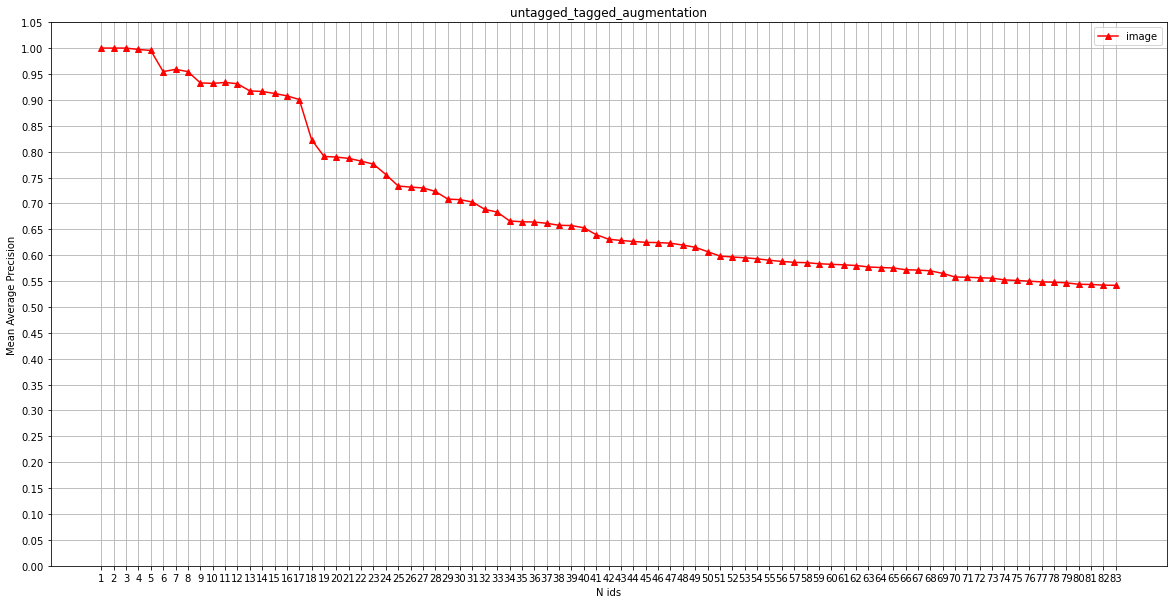

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(nids, mAPs, "^-r", label="image")
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.10, 0.05));
plt.xticks(np.arange(1, len(nids) + 1, 1));
plt.xlabel("N ids")
plt.ylabel("Mean Average Precision");
plt.title("untagged_tagged_augmentation")
plt.legend()
plt.savefig("mAP_by_amount_of_ids.png")

In [15]:
df_dict = {"nids": nids, "mAPs": mAPs}
df = pd.DataFrame(df_dict)
# df.to_csv("cluster_by_id_image.csv")

In [24]:
TRACK_LEN=4
base_model = load_model(MODEL)
track_model = tf.keras.Sequential()
track_model.add(tf.keras.layers.TimeDistributed(base_model, input_shape=(TRACK_LEN, 56, 56, 3)))
track_model.add(tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=1)))
track_model.summary()

# TRACK_LEN=4
# batch_size = 1

# def random_sampling(x):
#     rand_idx = tf.random.uniform(shape=[], maxval=TRACK_LEN, dtype=tf.int32)
#     return x[:, rand_idx, :]
    

# # base_model = load_model(MODEL)
# track_model = tf.keras.Sequential()
# track_model.add(tf.keras.layers.TimeDistributed(base_model, input_shape=(TRACK_LEN, 56, 56, 3)))
# track_model.add(tf.keras.layers.Lambda(random_sampling))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 4, 128)            1815040   
_________________________________________________________________
lambda_2 (Lambda)            (None, 128)               0         
Total params: 1,815,040
Trainable params: 1,814,336
Non-trainable params: 704
_________________________________________________________________


In [16]:
queryG = get_query_galleries_tracks(track_model, track_len=4, timegap=15, timegap_unit="m", batch_size=64)

4/4 [==============================] - 1s 126ms/step
Evaluating 228 tracks.


In [31]:
APs = defaultdict(list)
for qg in queryG:
    
    query, gallery = qg
    query_id = query.track_tag_id
    query = np.expand_dims(query.emb, axis=0)

    labels = gallery.track_tag_id.values
    distances = tf.matmul(query, to_np_array(gallery["emb"].values).T)
    distances = np.squeeze(distances.numpy())
    distances

    binary_labels = (labels == query_id).astype(bool)

    precision, recall, thresholds = precision_recall_curve(binary_labels, distances)

    AP = auc(recall, precision)
    APs[query_id].append(AP)
mAPs = dict()
mAPs["id"] = list()
mAPs["mAP"] = list()
for tag_id in APs:
    mAPs["id"].append(tag_id)
    mAPs["mAP"].append(np.mean(APs[tag_id]))
    
sorted_indx = np.argsort(mAPs["mAP"])[::-1]
# sorted_indx2 = np.argsort(mAPs["top1"])[::-1]

current_APs = []
tnids = list()
tNmAPs = list()
sorted_tags_ids = list()
for n, i in enumerate(sorted_indx):
    tag_id = mAPs["id"][i]
    sorted_tags_ids.append(tag_id)
    current_APs += APs[tag_id]
    tNmAPs.append(np.mean(current_APs))
    tnids.append(n + 1)

KeyError: 'top1'

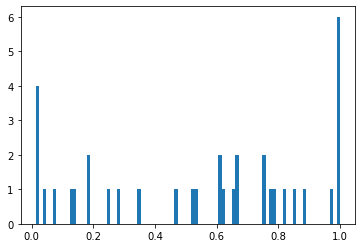

In [33]:
plt.hist(mAPs["mAP"], bins=90);

In [18]:
def mAP_track_model_evaluation_nids(track_model, ids, track_len=5, timegap=15, timegap_unit="m", batch_size=64):
    tf.random.set_seed(42)
    # df preprocessing
    test_df = pd.read_csv(EVALUATION_FILES["test"])
    test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])
    
    # filter tracks by minimum len
    tracks = test_df.groupby("global_track_id").filter(lambda x: len(x) >= track_len)
    
    # sample track_len images per track
    tracks = tracks.groupby("global_track_id").sample(track_len).sort_values(["global_track_id", "datetime2"])
    
    tracks_ids = tracks["global_track_id"].values[::track_len]
    track_tag_id = tracks["track_tag_id"].values[::track_len]
    datetime = tracks["datetime2"].values[::track_len]
    filenames = tracks["filename"].values
    images = filename2image(filenames)
    predictions = track_model.predict(images.batch(track_len).batch(batch_size), verbose=True)
    tracks_emb = pd.DataFrame({"datetime": datetime, "track_tag_id":track_tag_id, "global_track_id": tracks_ids, "emb": list(predictions)})
    
    eval_tracks = len(tracks_emb)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    # filtering those ids that at least have 2 tracks
    selected_track_tag_id = tracks_emb.track_tag_id.value_counts()[(tracks_emb.track_tag_id.value_counts() > 1)].index
    gtracks = tracks_emb[tracks_emb.track_tag_id.isin(selected_track_tag_id)].global_track_id.unique()
    
    APs = list()
    
    queries_num = 0
    for gtrack in gtracks:
        is_same_track = (tracks_emb.global_track_id == gtrack)
        query_row = tracks_emb[is_same_track].iloc[0]
        
        is_same_id = (query_row.track_tag_id == tracks_emb.track_tag_id)
        is_enough_timegap = np.abs(tracks_emb.datetime - query_row.datetime).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        gallery_df = tracks_emb[(is_enough_timegap & is_same_id & ~is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values

        query_id = query_row.track_tag_id
        query = np.expand_dims(query_row.emb, axis=0)
        distances = tf.matmul(query, gallery.T)
        distances = np.squeeze(distances.numpy())

        binary_labels = (labels == query_id).astype(bool)

        precision, recall, thresholds = precision_recall_curve(binary_labels, distances)

        AP = auc(recall, precision)
        APs.append(AP)
        queries_num += 1
        
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(APs)


def topN_track_model_evaluation(track_model, ids, N=1, track_len=5, timegap=15, timegap_unit="m", batch_size=64):
    
    # df preprocessing
    test_df = pd.read_csv(EVALUATION_FILES["test"])
    test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])
    
    # filter tracks by minimum len
    tracks = test_df.groupby("global_track_id").filter(lambda x: len(x) >= track_len)
    
    # sample track_len images per track
    tracks = tracks.groupby("global_track_id").sample(track_len).sort_values(["global_track_id", "datetime2"])
    
    tracks_ids = tracks["global_track_id"].values[::track_len]
    track_tag_id = tracks["track_tag_id"].values[::track_len]
    datetime = tracks["datetime2"].values[::track_len]
    filenames = tracks["filename"].values
    images = filename2image(filenames)
    predictions = track_model.predict(images.batch(track_len).batch(batch_size), verbose=True)
    tracks_emb = pd.DataFrame({"datetime": datetime, "track_tag_id":track_tag_id, "global_track_id": tracks_ids, "emb": list(predictions)})
    
    eval_tracks = len(tracks_emb)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    # filtering those ids that at least have 2 tracks
    selected_track_tag_id = tracks_emb.track_tag_id.value_counts()[(tracks_emb.track_tag_id.value_counts() > 1)].index
    gtracks = tracks_emb[tracks_emb.track_tag_id.isin(selected_track_tag_id)].global_track_id.unique()
    
    ACCs = list()
    
    queries_num = 0
    for gtrack in gtracks:
        is_same_track = (tracks_emb.global_track_id == gtrack)
        query_row = tracks_emb[is_same_track].iloc[0]
        
        is_same_id = (query_row.track_tag_id == tracks_emb.track_tag_id)
        is_enough_timegap = np.abs(tracks_emb.datetime - query_row.datetime).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        gallery_df = tracks_emb[(is_enough_timegap & is_same_id & ~is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values

        query_id = query_row.track_tag_id
        query = np.expand_dims(query_row.emb, axis=0)
        distances = tf.matmul(query, gallery.T)
        distances = np.squeeze(distances.numpy())

        min_idx = np.argsort(distances)

        predicted_ids = labels[min_idx[-N:]]

        acc = np.any(predicted_ids == query_id)
        ACCs.append(acc)
        queries_num += 1
        
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(ACCs)

In [35]:
current_ids = []
tnids = list()
tmAPs = list()
for i, tid in enumerate(sorted_tags_ids):
    current_ids.append(tid)
    if i == 0:
        current_mAP = 1.0
    else:
        current_mAP = mAP_track_model_evaluation_nids(track_model, current_ids, track_len=TRACK_LEN)
    tmAPs.append(current_mAP)
    tnids.append(i+1)

1/1 [==============================] - 0s 2ms/step
Evaluating 4 tracks.
Evaluating 4 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 6 tracks.
Evaluating 6 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 8 tracks.
Evaluating 8 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 10 tracks.
Evaluating 10 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 13 tracks.
Evaluating 13 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 21 tracks.
Evaluating 21 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 25 tracks.
Evaluating 25 queries.
1/1 [==============================] - 0s 10ms/step
Evaluating 31 tracks.
Evaluating 31 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 58 tracks.
Evaluating 58 queries.
2/2 [==============================] - 0s 13ms/step
Evaluating 66 tracks.
Evaluating 66 queries.
2/2 [==============================] - 0s 20

In [27]:
# df = pd.read_csv("cluster_by_id_track_average.csv")
# tnids = df.nids
# tmAPs = df.mAPs

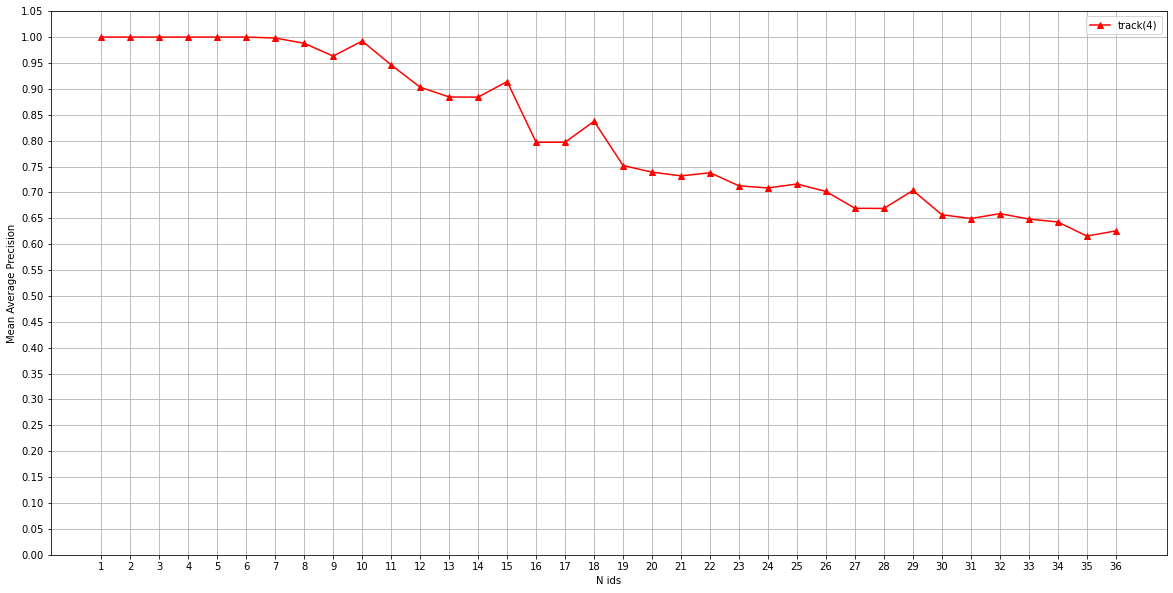

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(tnids, tmAPs, "^-r", label="track(4)")
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.10, 0.05));
plt.xticks(np.arange(1, len(tnids) + 1, 1));
plt.xlabel("N ids")
plt.ylabel("Mean Average Precision");
plt.legend()
# plt.savefig("mAp_by_amount_of_ids_track_average.png")
plt.savefig("mAp_by_amount_of_ids_track_random.png")

In [37]:
df_dict = {"nids": tnids, "mAPs": tmAPs}
df = pd.DataFrame(df_dict)
# df.to_csv("cluster_by_id_track_average.csv")
df.to_csv("cluster_by_id_track_random.csv")

In [3]:
avg_track_df = pd.read_csv("cluster_by_id_track_average.csv")
rand_track_df = pd.read_csv("cluster_by_id_track_random.csv")

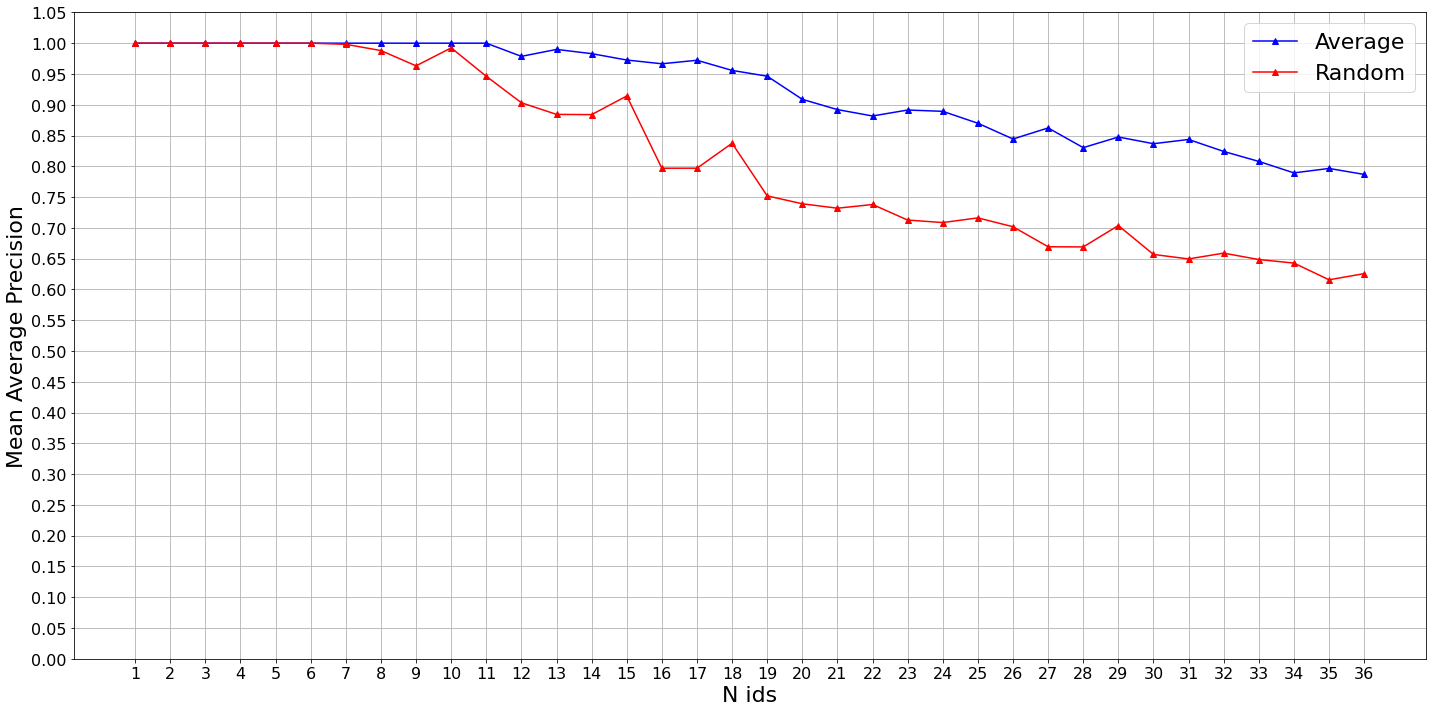

In [11]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
avg_track_df.plot(x="nids", y="mAPs", style="^-b", label="Average", ax=ax)
rand_track_df.plot(x="nids", y="mAPs", style="^-r", label="Random", ax =ax)
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.10, 0.05), fontsize=16);
plt.xticks(np.arange(1, len(avg_track_df) + 1, 1), fontsize=16);
plt.xlabel("N ids", fontsize=22)
plt.ylabel("Mean Average Precision", fontsize=22);
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig("mAP_track_reid_average_vs_random.png", bbox_inches="tight")

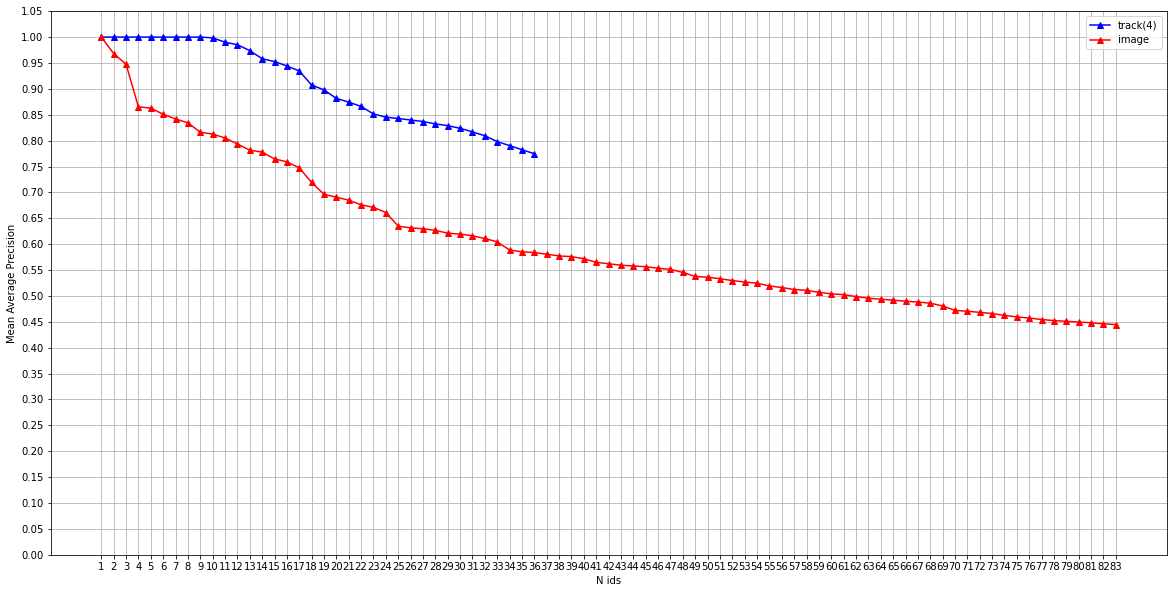

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(tnids, tNmAPs, "^-b", label="track(4)")
plt.plot(nids, NmAPs, "^-r", label="image")
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.10, 0.05));
plt.xticks(np.arange(1, len(nids) + 1, 1));
plt.xlabel("N ids")
plt.ylabel("Mean Average Precision");
plt.legend()

In [15]:
def mAP_evaluation_nids(model, ids, timegap=15, timegap_unit="m", batch_size=256):
    test_df = pd.read_csv(EVALUATION_FILES["test"])
    test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    APs = list()
    
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    queries_num = 0

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        
        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
            
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = tf.matmul(query, gallery.T)
            distances = np.squeeze(distances.numpy())

            binary_labels = (labels == query_id).astype(bool)

            precision, recall, thresholds = precision_recall_curve(binary_labels, distances)

            AP = auc(recall, precision)
            APs.append(AP)
            queries_num += 1
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(APs)

In [17]:
current_ids = []
nids = list()
mAPs = list()
for i, tid in enumerate(sorted_tags_ids):
    current_ids.append(tid)
    current_mAP = mAP_evaluation_nids(model, current_ids)
    mAPs.append(current_mAP)
    nids.append(i+1)

NameError: name 'model' is not defined

In [25]:
current_ids = []
tnids = list()
ttop1 = list()
for i, tid in enumerate(sorted_tags_ids):
    current_ids.append(tid)
    if i == 0:
        current_top1= 1.0
    else:
        current_top1= topN_track_model_evaluation(track_model, current_ids, N=1, track_len=TRACK_LEN)
    ttop1.append(current_top1)
    tnids.append(i+1)

1/1 [==============================] - 0s 2ms/step
Evaluating 5 tracks.
Evaluating 5 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 7 tracks.
Evaluating 7 queries.
1/1 [==============================] - 0s 2ms/step
Evaluating 9 tracks.
Evaluating 9 queries.
1/1 [==============================] - 0s 3ms/step
Evaluating 11 tracks.
Evaluating 11 queries.
1/1 [==============================] - 0s 4ms/step
Evaluating 14 tracks.
Evaluating 14 queries.
1/1 [==============================] - 0s 8ms/step
Evaluating 24 tracks.
Evaluating 24 queries.
1/1 [==============================] - 0s 12ms/step
Evaluating 32 tracks.
Evaluating 32 queries.
1/1 [==============================] - 0s 14ms/step
Evaluating 38 tracks.
Evaluating 38 queries.
2/2 [==============================] - 0s 13ms/step
Evaluating 65 tracks.
Evaluating 65 queries.
2/2 [==============================] - 0s 14ms/step
Evaluating 69 tracks.
Evaluating 69 queries.
2/2 [==============================] - 0s 

In [28]:
df_dict = {"nids": tnids, "top1": ttop1}
df = pd.DataFrame(df_dict)
df.to_csv("cluster_by_id_track_average_top1.csv")
# df.to_csv("cluster_by_id_track_random_top1.csv")

In [29]:
avg_track_df = pd.read_csv("cluster_by_id_track_average_top1.csv")
rand_track_df = pd.read_csv("cluster_by_id_track_random_top1.csv")

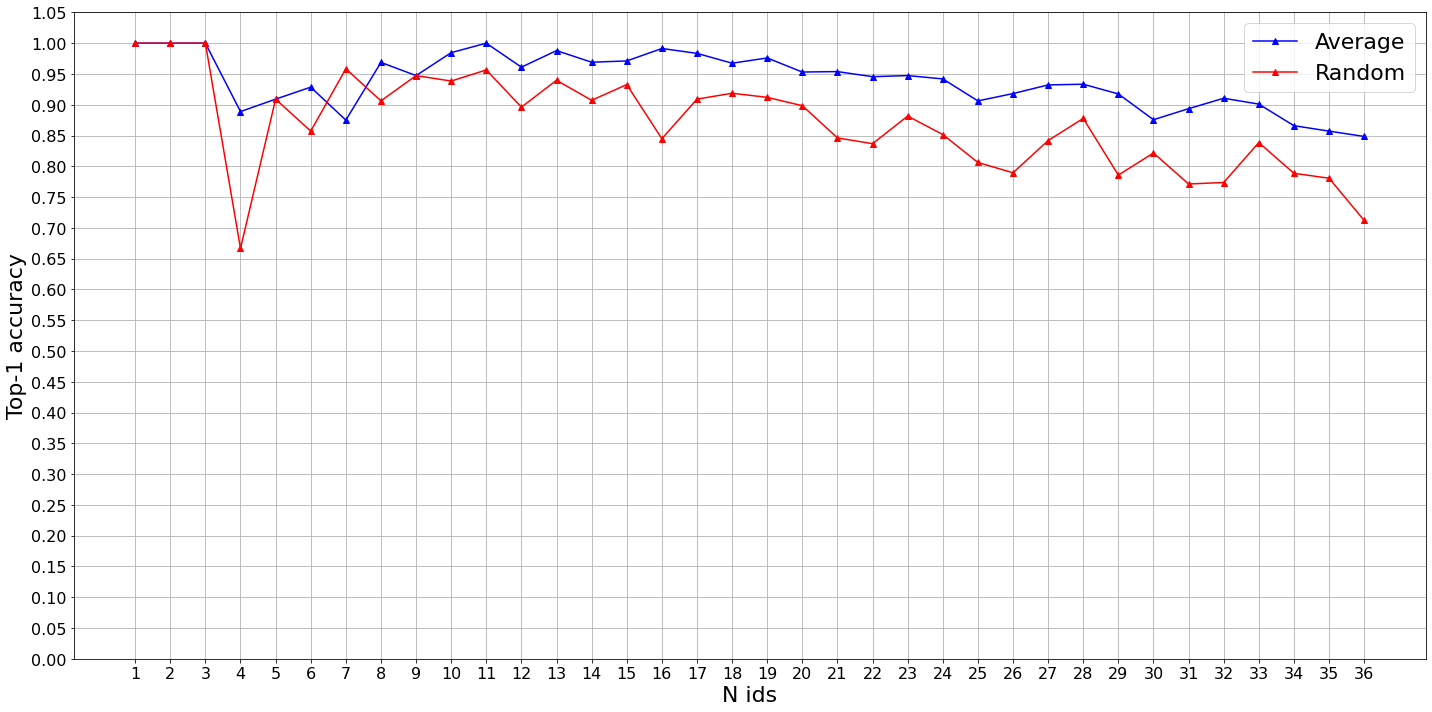

In [30]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
avg_track_df.plot(x="nids", y="top1", style="^-b", label="Average", ax=ax)
rand_track_df.plot(x="nids", y="top1", style="^-r", label="Random", ax =ax)
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.10, 0.05), fontsize=16);
plt.xticks(np.arange(1, len(rand_track_df) + 1, 1), fontsize=16);
plt.xlabel("N ids", fontsize=22)
plt.ylabel("Top-1 accuracy", fontsize=22);
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig("top1_track_reid_average_vs_random.png", bbox_inches="tight")

In [79]:
def get_query_gallery_track(track_model, N=1, track_len=5, timegap=15, timegap_unit="m", batch_size=64):
    
    # df preprocessing
    test_df = pd.read_csv(EVALUATION_FILES["test"])
#     test_df = test_df[test_df.track_tag_id.isin(ids)]
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])
    
    # filter tracks by minimum len
    tracks = test_df.groupby("global_track_id").filter(lambda x: len(x) >= track_len)
    
    # sample track_len images per track
    tracks = tracks.groupby("global_track_id").sample(track_len).sort_values(["global_track_id", "datetime2"])
    
    tracks_ids = tracks["global_track_id"].values[::track_len]
    track_tag_id = tracks["track_tag_id"].values[::track_len]
    datetime = tracks["datetime2"].values[::track_len]
    filenames = tracks["filename"].values
    filenames2 = filenames.reshape(-1, track_len).tolist()
    images = filename2image(filenames)
    predictions = track_model.predict(images.batch(track_len).batch(batch_size), verbose=True)
    tracks_emb = pd.DataFrame({"datetime": datetime, "track_tag_id":track_tag_id,
                               "global_track_id": tracks_ids, "emb": list(predictions),
                              "filenames": filenames2})
    
    eval_tracks = len(tracks_emb)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    # filtering those ids that at least have 2 tracks
    selected_track_tag_id = tracks_emb.track_tag_id.value_counts()[(tracks_emb.track_tag_id.value_counts() > 1)].index
    gtracks = tracks_emb[tracks_emb.track_tag_id.isin(selected_track_tag_id)].global_track_id.unique()
    
    ACCs = list()
    output = list()
    queries_num = 0
    for gtrack in gtracks:
        is_same_track = (tracks_emb.global_track_id == gtrack)
        query_row = tracks_emb[is_same_track].iloc[0]
        
        is_same_id = (query_row.track_tag_id == tracks_emb.track_tag_id)
        is_enough_timegap = np.abs(tracks_emb.datetime - query_row.datetime).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        gallery_df = tracks_emb[(is_enough_timegap & is_same_id & ~is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
        
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values

        query_id = query_row.track_tag_id
        query = np.expand_dims(query_row.emb, axis=0)
        distances = tf.matmul(query, gallery.T)
        distances = np.squeeze(distances.numpy())
        gallery_df.loc[gallery_df.index, "dist"] = distances
        output.append((query_row, gallery_df))

#         min_idx = np.argsort(distances)

#         predicted_ids = labels[min_idx[-N:]]

#         acc = np.any(predicted_ids == query_id)
#         ACCs.append(acc)
#         queries_num += 1
        
#     print("Evaluating {} queries.".format(queries_num))
    return output

In [80]:
qg = get_query_gallery_track(track_model,  N=1, track_len=4)

4/4 [==============================] - 0s 84ms/step
Evaluating 228 tracks.


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [109]:
def get_abdomen(image):
    
    if tf.shape(image)[0] == 512:
        return image[272:496, 144:368,:]
    else:
        return image[16:240, 16:240,:]

def plot_query_gallery(query_gallery, abdomens_only=False):
    query, gallery = query_gallery
    sorted_gallery = gallery.sort_values("dist", ascending=False)
    gallery_tag_ids =sorted_gallery.track_tag_id.values
    gallery_filenames =sorted_gallery.filenames.values
    gallery_images = list()
    for i in range(10):
        gimages = [io.imread(j) for j in  gallery_filenames[i]]
        if abdomens_only:
            gimages = [get_abdomen(l) for l in gimages]
        gallery_images.append(gimages)
    
    query_id = query.track_tag_id 
    qimages =[io.imread(i) for i in  query.filenames]
    
    if abdomens_only:
        qimages = [get_abdomen(i) for i in qimages]
        
    
    
    fig, ax = plt.subplots(4, 11, figsize=(20, 10))
    
    ax[0, 0].set_title(f"{query_id}")
    for i in range(4):
        
        ax[i, 0].imshow(qimages[i])
        ax[i, 0].set_yticks([])
        ax[i, 0].set_xticks([])
    
    for j in range(10):
        color = "green" if query_id == gallery_tag_ids[j] else "red"
        for i in range(4):
            if i == 0:
                ax[i, j+1].set_title(f"{gallery_tag_ids[j]}", color=color)
            ax[i, j+1].imshow(gallery_images[j][i])
            ax[i, j+1].set_xticks([])
            ax[i, j+1].set_yticks([])
            ax[i, j+1].spines['bottom'].set_color(color)
            ax[i, j+1].spines['top'].set_color(color) 
            ax[i, j+1].spines['right'].set_color(color)
            ax[i, j+1].spines['left'].set_color(color)
        

In [104]:
from random import choice

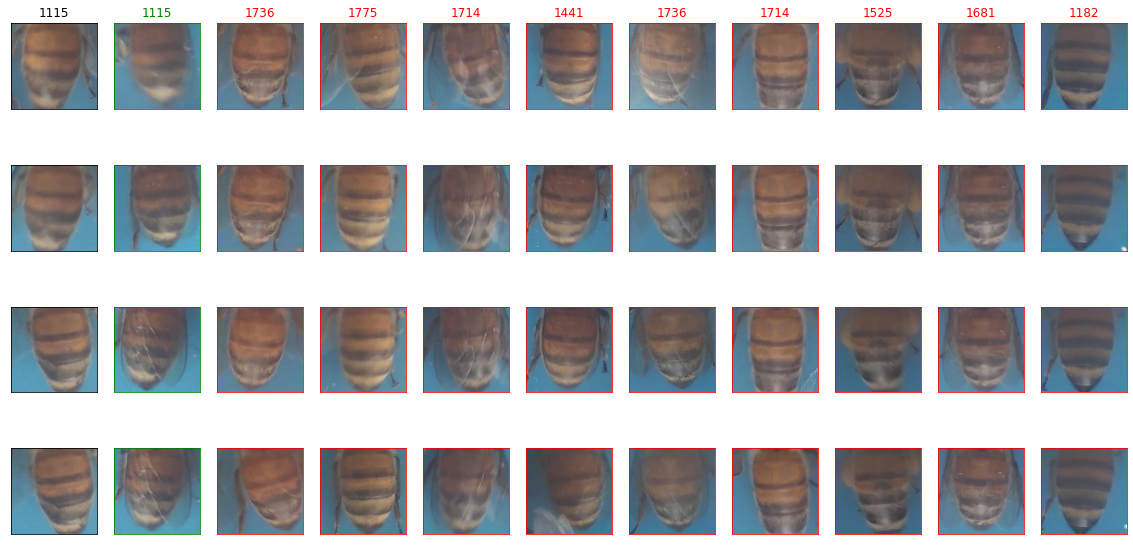

In [114]:
t = choice(qg)
plot_query_gallery(t, abdomens_only=True)

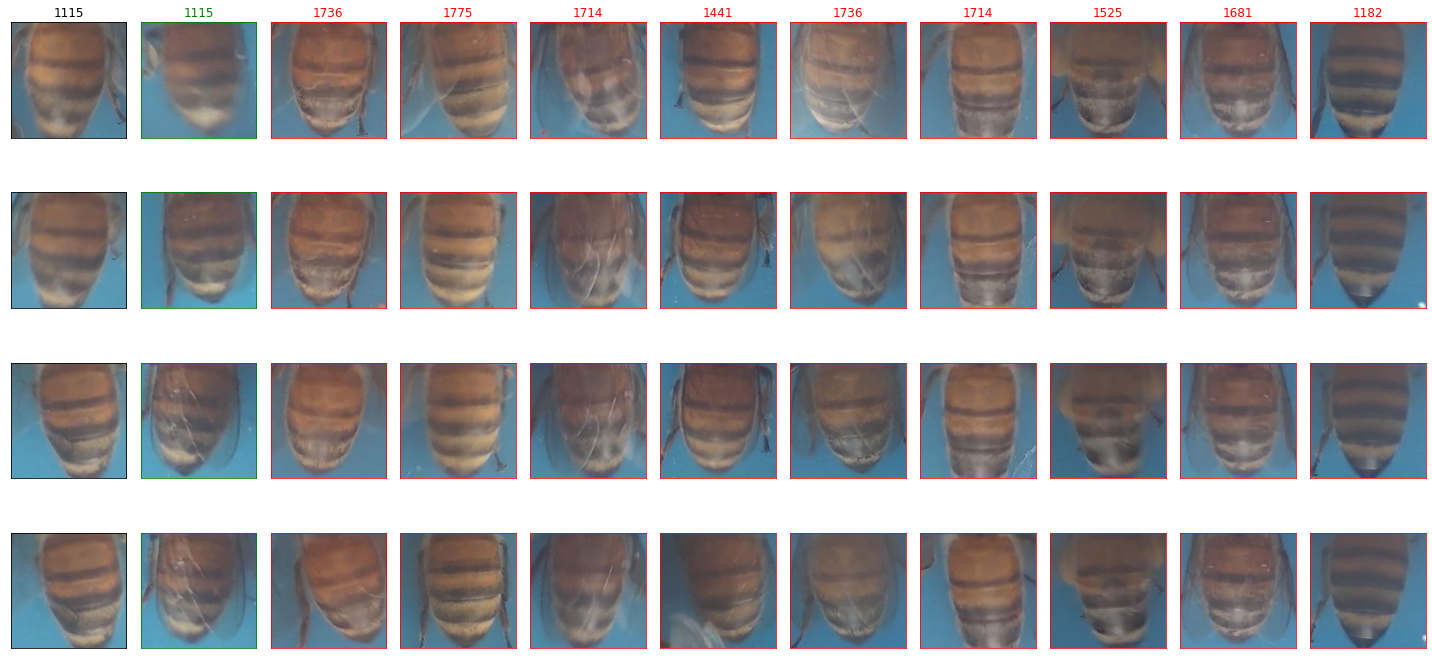

In [115]:
plot_query_gallery(t, abdomens_only=True)
plt.tight_layout()
plt.savefig("track-gallery-example.png", bbox_inches="tight")